Creo un dictionary in cui riporto tutti i modelli che andrò ad analizzare

In [72]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
from funzioni import plot_bias_tos
from funzioni import plot_bias_2_models_tos
from funzioni import plot_mean_cluster_tos

In [73]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

In [74]:
import pylab as pl
import plotly.express as px
import dill
import pickle
import cartopy.crs as ccrs

In [75]:
#cdo = Cdo()

In [76]:
# creo un dizionario in cui andrò a mettere tutti i modelli dentro
models = {}

In [77]:
#Costruisco il dizionario models con il nome del modello, il nomde del percorso di tutti i file *.nc di ogni modello e il nome di .nc, cioè il modello remapbil

#Percorso dei file
name_models = '/work/users/guest/sbeltrami/prova/name_ocean_model.txt'
path_models = '/work/users/guest/sbeltrami/prova/path_ocean_model.txt'
path_remap_models = '/work/users/guest/sbeltrami/prova/path_remap_ocean_model.txt'
# Apro i 3 file in modalità di lettura
with open(name_models, 'r') as file:
    # Leggo tutte le righe del file e salvo in una lista
    lines_name_models = file.readlines()
with open(path_models, 'r') as file:
    lines_path_models = file.readlines()
with open(path_remap_models, 'r') as file:
    lines_path_remap_models = file.readlines()


# Itero su tutte le righe dei 3 file e organizzo i dati nel dizionario
for line_name, line_path, line_path_remap in zip(lines_name_models, lines_path_models, lines_path_remap_models): #zip per iterare sulle 3 liste contemporaneamente
    model_name = line_name.strip() #senza spazi bianchi
    #model_name è la chiave principale
    # Inizializzo il dizionario se non esiste ancora
    if model_name not in models:
        models[model_name] = {}
    # Aggiungo name, path, path remap come sottochiavi
    models[model_name]['name'] = model_name
    models[model_name]['path'] = line_path.strip()
    models[model_name]['path remap'] = line_path_remap.strip()

In [78]:
for name in models.keys():
    path_remap = models[name]['path remap']
    if os.path.exists(path_remap): #Se il file esiste
        # Apro il dataset
        models[name]['dataset'] = xr.open_dataset(path_remap)
        dataset = models[name]['dataset']
        #peso il dataset
        models[name]['dataset weighted'] = compute_dataset_weighted(dataset["tos"])
        #medie annuali con dataset pesato
        models[name]['dataset annual mean'] = compute_annual_mean_weighted(models[name]['dataset weighted'])
        print(models[name]['name']) 

        #Seleziono il box del Nord Atlantico
        models[name]['North Atlantic box'] = dataset.sel(lon=slice(280,360), lat=slice(20,80))
        na_box = models[name]['North Atlantic box']
        #peso il dataset Nord Atlantico
        models[name]['North Atlantic dataset weighted'] = compute_dataset_weighted(na_box["tos"])
        #calcolo la media annuale del dataset Nord Atlantico
        models[name]['North Atlantic annual mean weighted'] = compute_annual_mean_weighted(models[name]['North Atlantic dataset weighted'])
        #Seleziono la climatologia
        na_box_climat = na_box.sel(time=slice("1982-01", "2014-12"))
        #peso il dataset del periodo scelto per la climatologia
        models[name]['North Atlantic climatology weighted'] = compute_dataset_weighted(na_box_climat["tos"])
        #calcolo la media annuale del dataset na sul periodo scelto
        models[name]['North Atlantic annual mean climatology'] = compute_annual_mean_weighted(models[name]['North Atlantic climatology weighted'])
        #Calcolo l'anomalia di tos rispetto alla climatologia scelta
        models[name]['North Atlantic anomaly'] = compute_anomaly(models[name]['North Atlantic annual mean weighted'],models[name]['North Atlantic annual mean climatology'])
    else:
        print(f"Errore: Il file {path_remap} non esiste per il modello {name}")

TaiESM1
AWI-CM-1-1-MR
AWI-ESM-1-1-LR
BCC-CSM2-MR
BCC-ESM1
CAMS-CSM1-0
CAS-ESM2-0
FGOALS-g3
CanESM5
CMCC-CM2-SR5
ACCESS-ESM1-5
ACCESS-CM2
E3SM-1-0
EC-Earth3
EC-Earth3-Veg
FIO-ESM-2-0
MPI-ESM-1-2-HAM
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
GISS-E2-1-G
GISS-E2-1-G-CC
GISS-E2-1-H
CESM2
CESM2-FV2
CESM2-WACCM
CESM2-WACCM-FV2
NorESM2-LM
NorESM2-MM
GFDL-ESM4
NESM3
SAM0-UNICON
MCM-UA-1-0


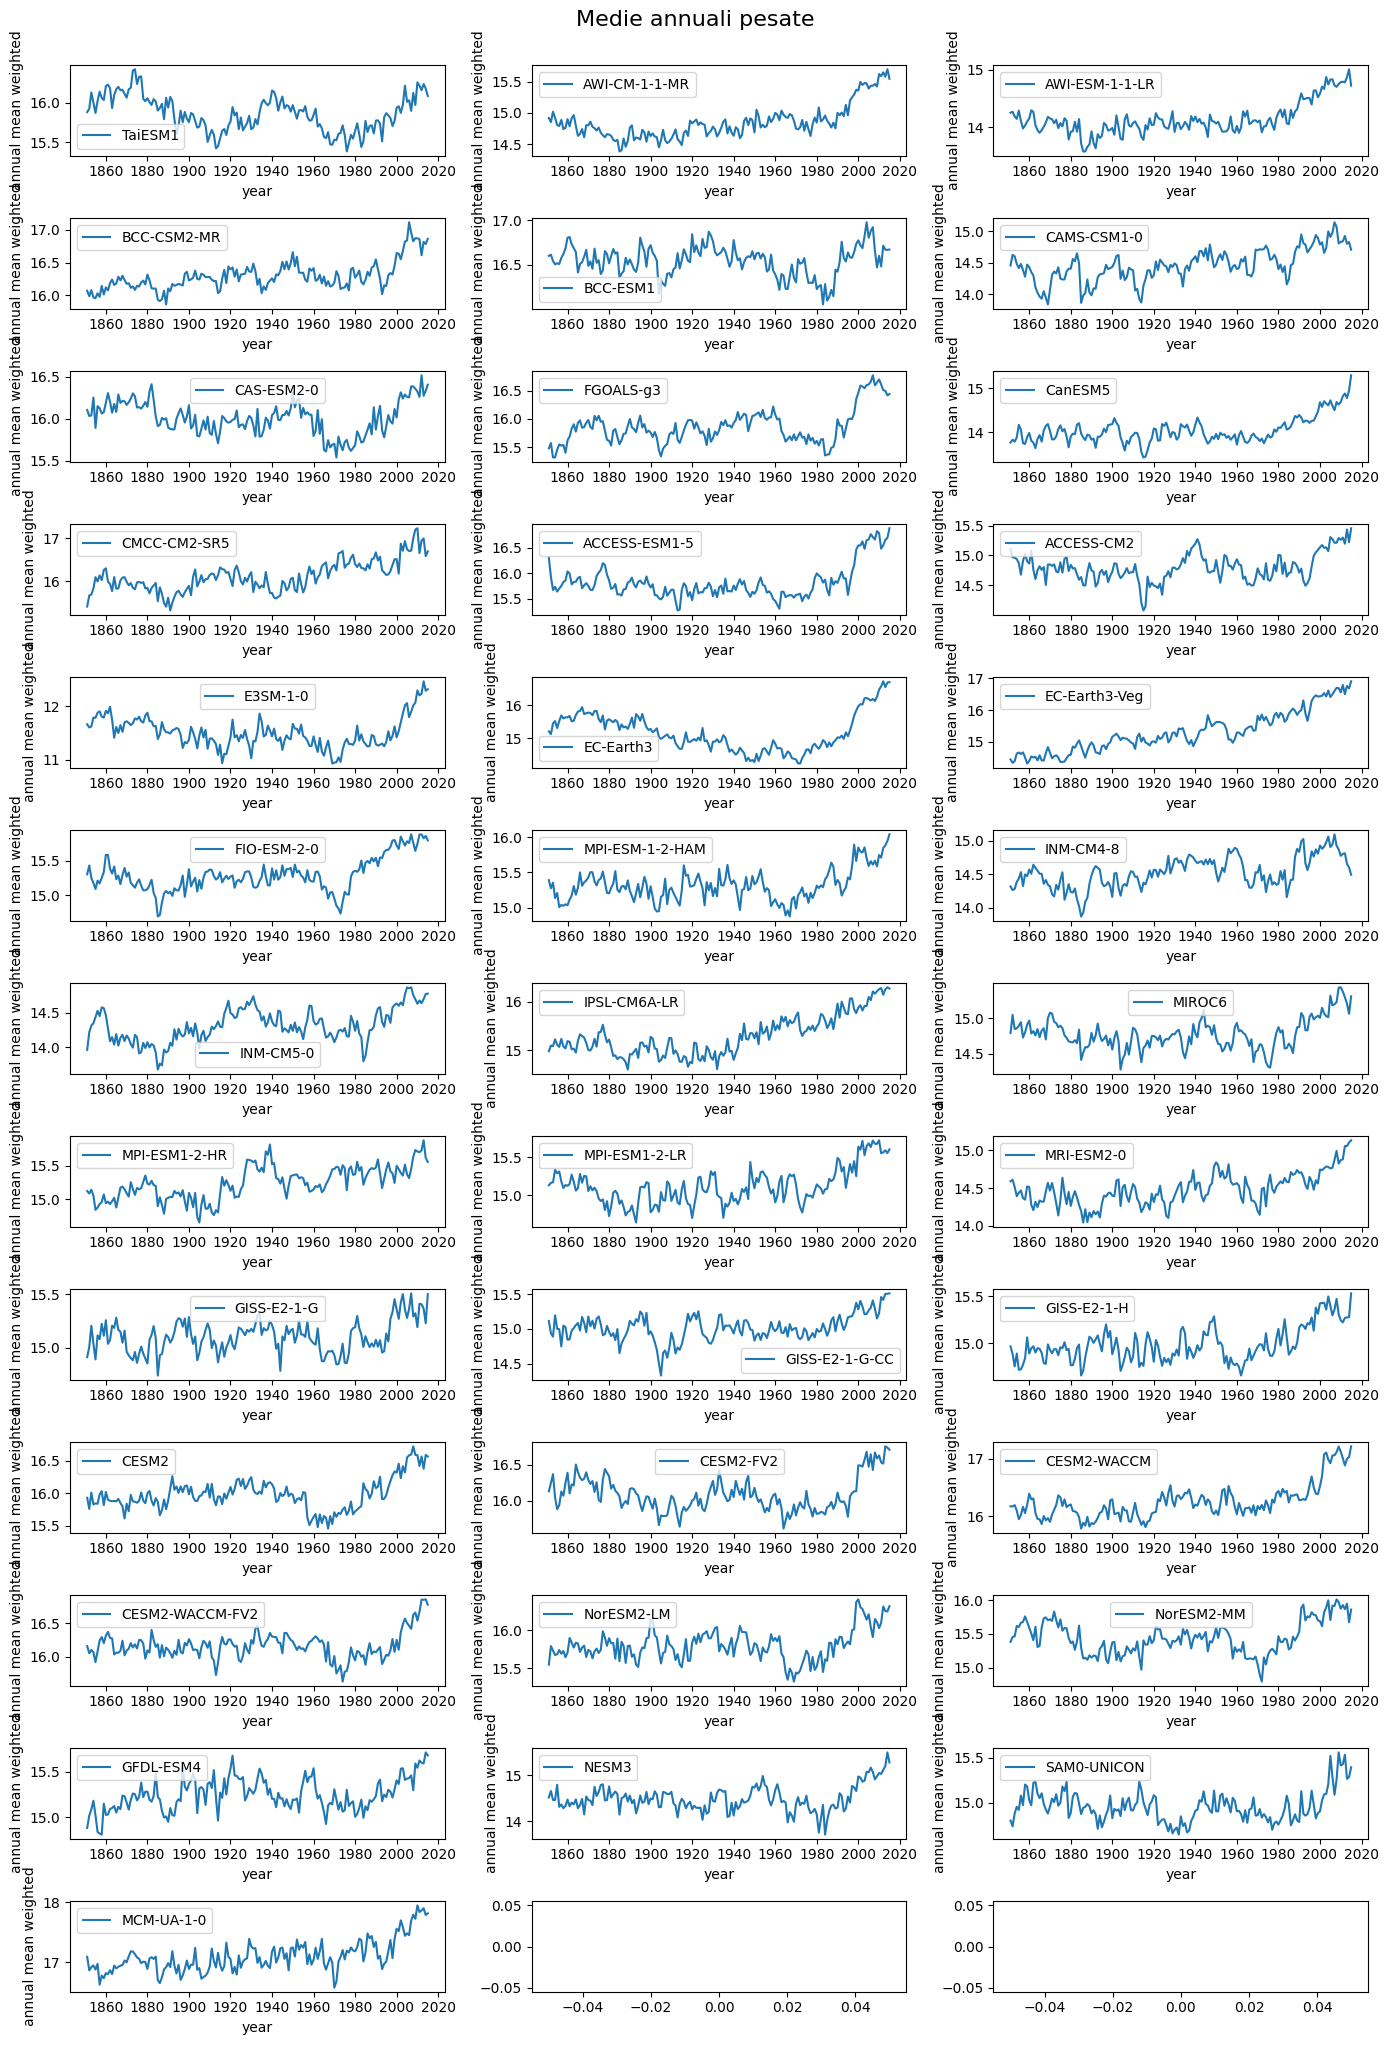

In [79]:
#Creo una lista con il nome dei modelli
models_list = list(models.keys())
#plot medie annuali dei modelli
fig, ax = plt.subplots(nrows=(int(len(models)/3)+1),ncols=3,figsize=(14,20))
# Plot dei modelli
for i in range(int(len(models)/3)+1): #ciclo sulle righe
    for j in range(3): #ciclo sulle colonne
        models_index_list = i * 3 + j #indice del modello all'interno della lista
        if models_index_list == len(models_list):
            break
        model_name = models_list[models_index_list]
        data_array = models[model_name]['North Atlantic annual mean weighted'].copy()
        data_array = data_array.assign_coords(time=data_array['time'].values.astype('datetime64[ns]')) #assegno un nuova coordinata tempo, .values restituisce i valori di time di data_array, converte i valori in datetime64[ns]
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()
        ax[i,j].set_ylabel('annual mean weighted')
        ax[i,j].set_xlabel('year')
        
for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()
# Titolo
fig.suptitle('Medie annuali pesate', fontsize=16, y=1.02)

plt.savefig('annual_mean_weighted.pdf', format='pdf')

In [80]:
models['TaiESM1']['North Atlantic anomaly']

<xarray.DataArray 'tos' (time: 165)> Size: 1kB
array([-8.75322186e-05,  4.12442621e-02,  2.48398366e-01,  1.18892828e-01,
       -1.18810310e-02,  1.39826880e-01,  2.58021376e-01,  1.79019181e-01,
        1.52132127e-01,  3.28764416e-01,  3.46468346e-01,  3.02973521e-01,
        5.02187140e-02,  2.16201955e-01,  2.88199937e-01,  3.18612762e-01,
        2.76137573e-01,  2.81522576e-01,  2.32837496e-01,  1.81872359e-01,
        2.87094464e-01,  3.07657702e-01,  5.25159079e-01,  5.41784264e-01,
        3.54403538e-01,  4.45661973e-01,  4.51772185e-01,  1.67899807e-01,
        1.37869020e-01,  1.75435615e-01,  1.26605011e-01,  9.01962385e-02,
        1.63774184e-01,  1.35151215e-01,  1.95121094e-02,  5.19166731e-02,
        1.04140264e-01, -9.10086545e-02,  1.81689246e-01,  5.69530457e-02,
        1.90782112e-01,  1.37558267e-01, -8.92947101e-02, -2.79532843e-01,
       -1.76216334e-01,  1.79283994e-02, -1.28000821e-01,  1.08018055e-03,
       -8.30072770e-02, -1.27440483e-01, -1.15273031e-02, -3.02336862e-02,
       -1.12858606e-01, -1.97481264e-01, -1.83538785e-01, -7.57120592e-02,
       -1.02820359e-01, -1.70809671e-01, -3.78285134e-01, -2.95368464e-01,
       -2.26048905e-01, -2.85167653e-01, -4.59403888e-01, -4.31477353e-01,
       -3.34712263e-01, -2.37535631e-01, -2.14631534e-01, -2.90329374e-01,
       -1.69872797e-01, -1.21936059e-01,  6.31974852e-02, -4.19128598e-02,
       -6.45138491e-03, -2.16379583e-01, -6.93906857e-02, -2.30919228e-01,
       -1.84083164e-01, -1.38530523e-01, -4.65718088e-02, -2.17431445e-01,
...
        1.20981198e-01,  2.72088736e-01,  2.54550596e-01,  1.76872528e-01,
        1.71998249e-02,  1.22208813e-01,  1.95875153e-01,  4.63308880e-02,
        8.68194310e-02,  7.40134720e-02,  4.99939368e-03,  8.78104716e-02,
        1.82690241e-03, -8.43589736e-02,  2.11833251e-02,  2.55368590e-02,
        7.28734820e-03,  7.56221890e-02, -5.85490723e-02, -1.06196464e-01,
       -1.05325796e-01, -3.65606222e-02,  4.23144667e-02, -1.82486148e-01,
       -1.54278795e-01, -2.05317741e-01, -3.13881642e-01, -3.30683644e-01,
       -2.53954013e-01, -4.09070537e-01, -4.14245570e-01, -3.48990921e-01,
       -3.56377511e-01, -2.75574843e-01, -2.64438116e-01, -1.68070247e-01,
       -2.88215731e-01, -4.98613943e-01, -3.90693621e-01, -2.87970729e-01,
       -3.35464919e-01, -2.38793999e-01, -1.42393536e-01, -2.82427105e-01,
       -4.42443090e-01, -3.72307397e-01, -1.12100561e-01, -2.52920426e-01,
       -1.75547377e-01, -1.67472508e-01, -2.70316575e-01, -1.08557778e-01,
       -1.04735689e-01, -1.47545537e-01, -3.71788081e-01, -6.39125762e-02,
       -1.44586292e-02, -4.22216022e-02, -7.43561350e-02, -1.77534697e-01,
       -1.13198447e-01,  5.43239539e-02,  7.34855307e-02, -1.07660547e-02,
        9.30113187e-02,  3.33071179e-01,  1.30133167e-01,  1.48556819e-01,
        1.53554502e-02,  2.41661103e-01,  8.97597346e-02,  3.76104335e-01,
        3.34776793e-01,  2.76916733e-01,  3.55154468e-01,  2.96890672e-01,
        2.02981901e-01])
Coordinates:
  * time     (time) object 1kB 1850-12-31 00:00:00 ... 2014-12-31 00:00:00

In [81]:
len(models)

37

Nord Atlantico anomalie - Dataset ESA-CCI

Text(0.5, 0.98, 'Anomalia Nord Atlantico ESA rispetto alla media climatologica 1982 - 2014')

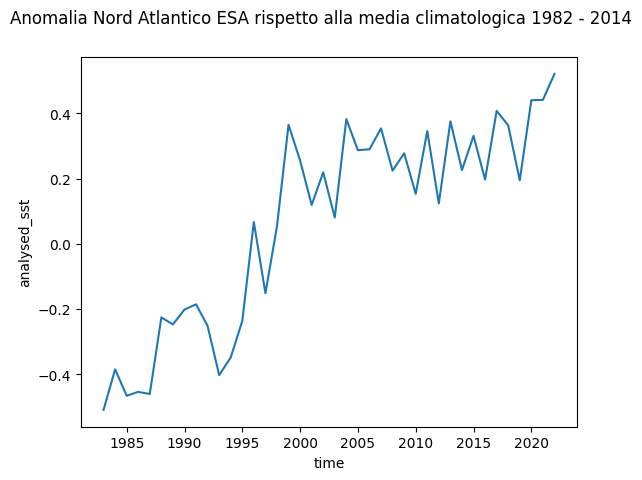

In [82]:
#ESA-CCI box Nord Atlantico
dataset_ESA_na=xr.open_dataset('/work/users/guest/sbeltrami/prova/ESA-CCI_SST_remap.nc').sel(lon=slice(280,360), lat=slice(20,80)) #seleziono lon lat del Nord Atlantico
dataset_ESA_na_celsius = convert_dataset_celsius(dataset_ESA_na["analysed_sst"]) #converto in °C
#dataset pesato
dataset_ESA_weighted_na = compute_dataset_weighted(dataset_ESA_na_celsius)
#media annuale Nord Atlantico
annual_mean_esa_na = compute_annual_mean_weighted(dataset_ESA_weighted_na)
#Scelgo periodo su cui calcolare la climatologia
esa_na_1982_2014 = dataset_ESA_na_celsius.sel(time=slice("1982-01", "2014-12"))
#peso il dataset del periodo scelto
esa_na_1982_2014_weighted = compute_dataset_weighted(esa_na_1982_2014)
#calcolo la media annuale sul periodo scelto
annual_mean_esa_na_30 = compute_annual_mean_weighted(esa_na_1982_2014_weighted)
#Calcolo l'anomalia di tos rispetto al periodo di riferimento scelto
anomaly_esa = compute_anomaly(annual_mean_esa_na,annual_mean_esa_na_30)
#plot
anomaly_esa.plot()
plt.suptitle('Anomalia Nord Atlantico ESA rispetto alla media climatologica 1982 - 2014')

Plot anomalia Nord Atlantico modelli e dataset ESA-CCI

In [83]:
anomaly_esa.time

<xarray.DataArray 'time' (time: 40)> Size: 320B
array(['1982-12-31T00:00:00.000000000', '1983-12-31T00:00:00.000000000',
       '1984-12-31T00:00:00.000000000', '1985-12-31T00:00:00.000000000',
       '1986-12-31T00:00:00.000000000', '1987-12-31T00:00:00.000000000',
       '1988-12-31T00:00:00.000000000', '1989-12-31T00:00:00.000000000',
       '1990-12-31T00:00:00.000000000', '1991-12-31T00:00:00.000000000',
       '1992-12-31T00:00:00.000000000', '1993-12-31T00:00:00.000000000',
       '1994-12-31T00:00:00.000000000', '1995-12-31T00:00:00.000000000',
       '1996-12-31T00:00:00.000000000', '1997-12-31T00:00:00.000000000',
       '1998-12-31T00:00:00.000000000', '1999-12-31T00:00:00.000000000',
       '2000-12-31T00:00:00.000000000', '2001-12-31T00:00:00.000000000',
       '2002-12-31T00:00:00.000000000', '2003-12-31T00:00:00.000000000',
       '2004-12-31T00:00:00.000000000', '2005-12-31T00:00:00.000000000',
       '2006-12-31T00:00:00.000000000', '2007-12-31T00:00:00.000000000',
       '2008-12-31T00:00:00.000000000', '2009-12-31T00:00:00.000000000',
       '2010-12-31T00:00:00.000000000', '2011-12-31T00:00:00.000000000',
       '2012-12-31T00:00:00.000000000', '2013-12-31T00:00:00.000000000',
       '2014-12-31T00:00:00.000000000', '2015-12-31T00:00:00.000000000',
       '2016-12-31T00:00:00.000000000', '2017-12-31T00:00:00.000000000',
       '2018-12-31T00:00:00.000000000', '2019-12-31T00:00:00.000000000',
       '2020-12-31T00:00:00.000000000', '2021-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 320B 1982-12-31 1983-12-31 ... 2021-12-31

In [84]:
#Nord Atlantico
#Creo una lista con il nome dei modelli
models_list = list(models.keys())

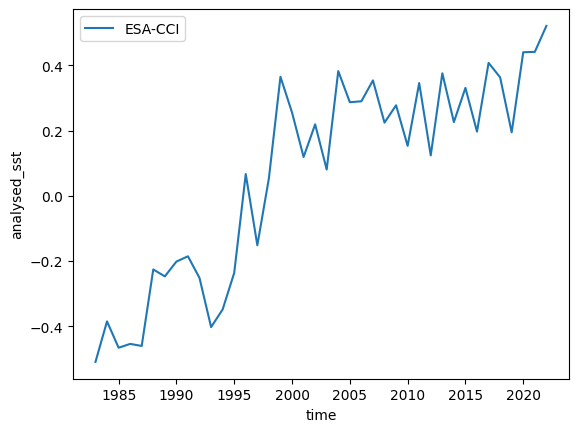

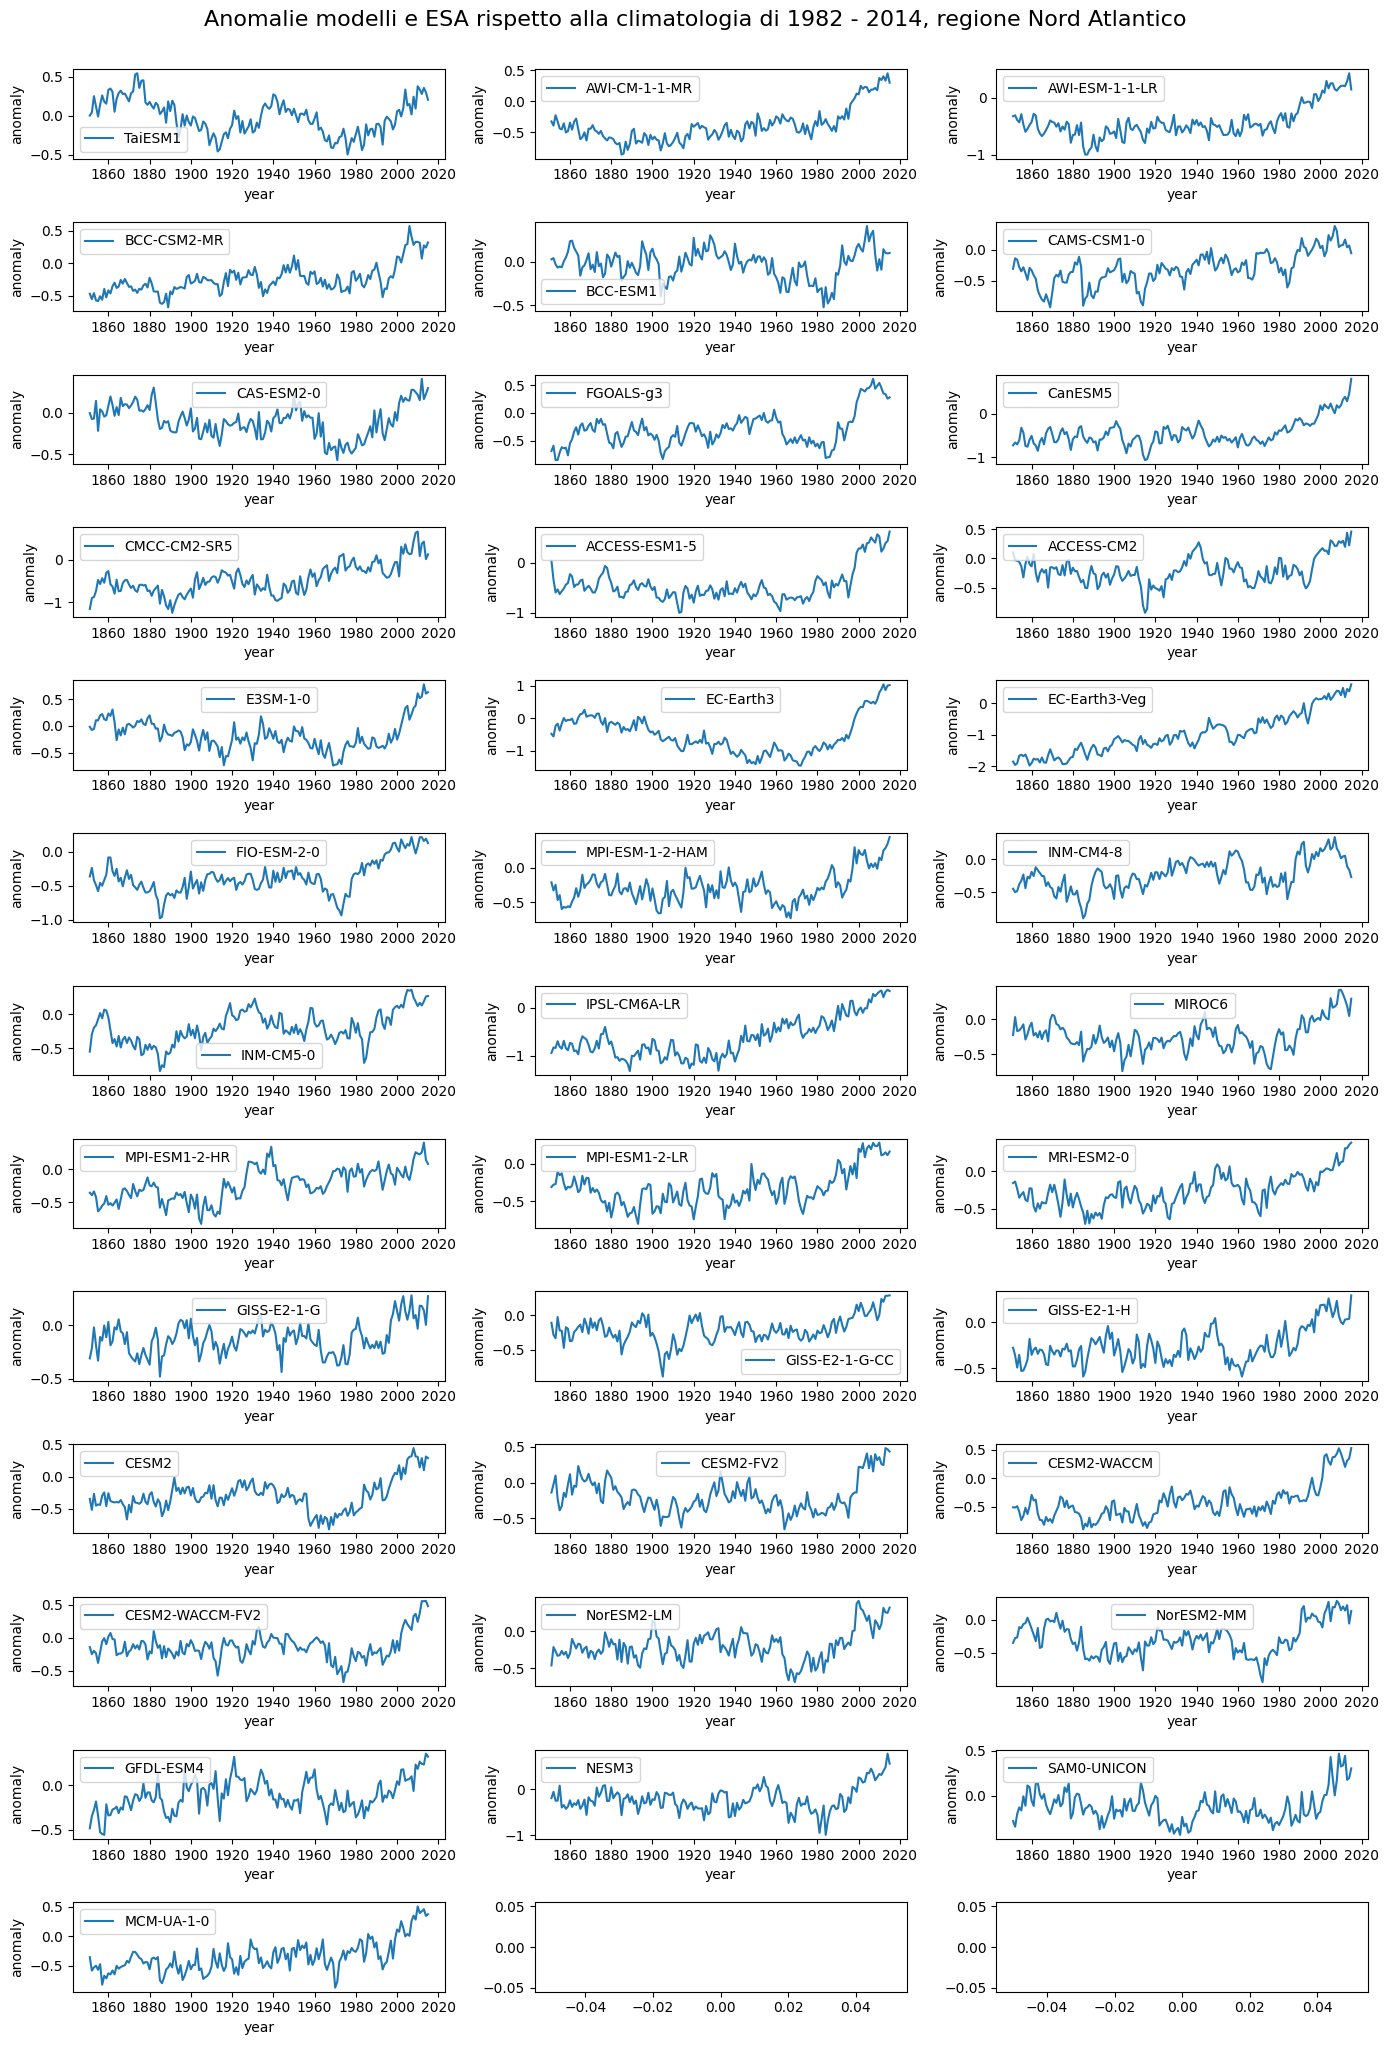

In [85]:
#Plot delle anomalie dei modelli e di ESA su periodo di riferimento 1984-2014
# Plot della anomalia di ESA-CCI
anomaly_esa.plot(label='ESA-CCI')
plt.legend()
#Plot dei modelli
fig, ax = plt.subplots(nrows=(int(len(models)/3)+1),ncols=3,figsize=(14,20))
# Plot dei modelli
for i in range((int(len(models)/3)+1)): #ciclo sulle righe
    for j in range(3): #ciclo sulle colonne
        models_index_list = i * 3 + j #indice del modello all'interno della lista
        if models_index_list == len(models_list):
            break
        model_name = models_list[models_index_list]
        data_array = models[model_name]['North Atlantic anomaly'].copy()
        data_array = data_array.assign_coords(time=data_array['time'].values.astype('datetime64[ns]')) #assegno un nuova coordinata tempo, .values restituisce i valori di time di data_array, converte i valori in datetime64[ns]
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()
        ax[i,j].set_ylabel('anomaly')
        ax[i,j].set_xlabel('year')
        
for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()
# Titolo
fig.suptitle('Anomalie modelli e ESA rispetto alla climatologia di 1982 - 2014, regione Nord Atlantico', fontsize=16, y=1.02)

plt.savefig('anomalies.pdf', format='pdf')

Bias : Medie stagionali (modello - osservazioni), con media climatologica delle osservazioni su periodo 1983 - 2014

Dataset ESA-CCI

In [86]:
#Dataset ESA - CCI
#Creo un dizionario in cui vado a mettere la media temporale per ogni stagione MAM, JJA, SON, DJF
esa_na_seas_mean_tos = {}

In [87]:
#Calcolo la media temporale su tutti e 4 i trimestri MAM = 1, JJA = 2, SON = 3, DJF = 4
for i in range(4):
    esa_na_seas_mean_tos[i+1] = compute_mean_resample_mar(dataset_ESA_na_celsius,"1982","2014",i)

In [88]:
esa_na_seas_mean_tos.keys()

dict_keys([1, 2, 3, 4])

Modelli

In [89]:
models['TaiESM1'].keys()

dict_keys(['name', 'path', 'path remap', 'dataset', 'dataset weighted', 'dataset annual mean', 'North Atlantic box', 'North Atlantic dataset weighted', 'North Atlantic annual mean weighted', 'North Atlantic climatology weighted', 'North Atlantic annual mean climatology', 'North Atlantic anomaly'])

In [90]:
#Bias modelli
for name in models:
    #Seleziono il box Nord Atlantico
    na_box = models[name]['North Atlantic box']
    #media temporale delle stagioni MAM, JJA, SON
    for i in range(4): # ciclo su tutte le stagioni
        #Calcolo la media temporale per ogni stagione dei modelli, per un anno --> da aggiungere anni!
        model_na_seas_mean = compute_mean_resample_mar(na_box["tos"],"1982","2014",i)
        #Calcolo il bias modelli - dataset
        if (i+1) == 1: # MAM
            models[name]['North Atlantic bias MAM'] = model_na_seas_mean - esa_na_seas_mean_tos[i+1]
        elif (i+1) == 2 : # JJA
            models[name]['North Atlantic bias JJA'] = model_na_seas_mean - esa_na_seas_mean_tos[i+1]
        elif (i+1) == 3 : #SON
            models[name]['North Atlantic bias SON'] = model_na_seas_mean - esa_na_seas_mean_tos[i+1]
        elif (i+1) == 4 : #DJF
            models[name]['North Atlantic bias DJF'] = model_na_seas_mean - esa_na_seas_mean_tos[i+1]

In [91]:
models['ACCESS-CM2']['North Atlantic bias DJF']

<xarray.DataArray (lat: 30, lon: 40)> Size: 5kB
array([[-0.26199913,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,  0.15197754, ...,         nan,
                nan,         nan],
       [        nan,         nan, -0.15270805, ...,         nan,
                nan,         nan],
       ...,
       [        nan, -0.01082683, -0.03363764, ..., -1.4337447 ,
        -1.1582531 , -0.78007174],
       [        nan,         nan,  0.07427239, ..., -0.39136565,
        -1.3315707 , -2.255495  ],
       [        nan,         nan,         nan, ...,  0.0539639 ,
        -0.02168727, -0.6356623 ]], dtype=float32)
Coordinates:
  * lon      (lon) float64 320B 280.0 282.0 284.0 286.0 ... 354.0 356.0 358.0
  * lat      (lat) float64 240B 21.0 23.0 25.0 27.0 29.0 ... 73.0 75.0 77.0 79.0

Creo la feature matrix con dimensioni = (37,30x40)

In [92]:
n_rows = len(models['ACCESS-CM2']['North Atlantic bias DJF'].lat.values) # prendo un modello generico e calcolo il numero di righe, pari al numero di grid cell sulla latitudine
n_cols = len(models['ACCESS-CM2']['North Atlantic bias DJF'].lon.values) #il numero di colonne è pari al numero di grid cell sulla longitudine
n_elements = n_rows * n_cols
n_models = len(models) # numero di modelli

In [93]:
np_array_models_2d = np.zeros((n_rows,n_cols)) #inizializzazione array 2-dim, che ha sulle colonne la longitudine e sulle righe la latitudine e andrò a mettere i valori dei bias di temperatura della stagione MAM
np_array_models_1d = np.zeros(n_elements) #inizializzazione array 1-dim, creato con righe di np_array_models_2d messe una accanto all'altra
feature_matrix_init = np.zeros((n_models,n_elements)) #inizializzazione matrice con righe pari al numero di modelli e per ogni riga vado a mettere 
i = 0 #inizializzazione indice righe feature_matrix_init
feature_matrix_init.shape

(37, 1200)

In [94]:
for name in models.keys(): #models_list è una lista contenente il nome di tutti i modelli che sto utilizzando. Quindi ciclo sul numero dei modelli
    #Creo array
    np_array_models_2d = models[name]['North Atlantic bias DJF'].values #estraggo i valori da bias MAM e li metto in un array 2d, dove sulle righe c'è la latitudine e sulle colonne la longitudine
    np_array_models_1d = np_array_models_2d.flatten() #array 1d con numero di elementi pari a lat x lon (messe una accanto all'altra le righe dell'array 2d precedente)
    #Creo feature matrix
    feature_matrix_init[i,:] = np_array_models_1d #ogni riga di feature_matrix_init è pari a np_array_models_1d
    i = i + 1 #aggiorno indice i

feature_matrix_init.shape

(37, 1200)

Elimino le colonne contenenti 'nan'

In [95]:
#Elimino le colonne che contengono almeno un nan e creo la feature_matrix
feature_matrix = np.empty((n_models,0)) #inizializzo la nuova feature matrix, cioè la matrice senza nan
number_nan = 0 #inizializzo il numero dei number nan
arr = np.zeros(n_models) #inizializzo array di dimensione pari al numero di modelli
cell_grid_nan = [] #lista vuota che contiene il numero delle celle della griglia che hanno elementi nan e che quindi vengono eliminate per il calcolo di feature_matrix

for j in range(n_elements): #ciclo sulle colonne di feature_matrix_init   
    if np.isnan(feature_matrix_init[:,j]).any(): #se c'è almeno un elemento nan all'interno della colonna
        cell_grid_nan.append(j) #costruisco la cella con il numero delle colonne che contengono elementi nan
        number_nan = number_nan + 1 #aggiorno il numero di colonne che hanno almeno un elemento nan
    else: #se la colonna non contiene nan
        arr = feature_matrix_init[:,j]
        feature_matrix = np.column_stack((feature_matrix,arr)) #aggiungo la colonna di feature_matrix_init senza nan alla matrice feature_matrix
    

In [96]:
print(cell_grid_nan)

[0, 1, 2, 3, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 153, 154, 155, 156, 157, 158, 159, 160, 193, 194, 195, 196, 197, 198, 199, 200, 235, 236, 237, 238, 239, 240, 241, 242, 275, 276, 277, 278, 279, 280, 281, 282, 317, 318, 319, 320, 321, 322, 323, 355, 356, 357, 358, 359, 360, 361, 362, 363, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 447, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 515, 516, 517, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 571, 572, 573, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688

In [97]:
len(cell_grid_nan)

510

In [98]:
feature_matrix.shape

(37, 690)

Plot delle grid cell che non vengono considerate perché contengono elementi nan

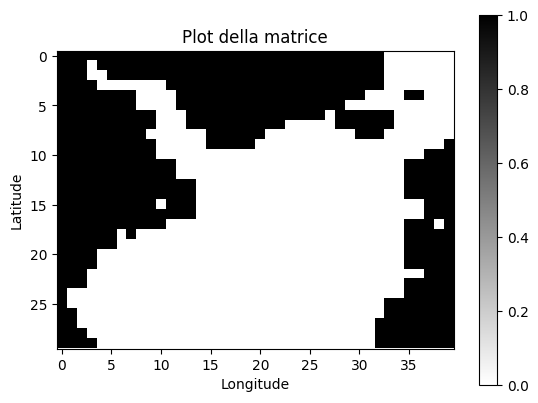

In [99]:
#Creo matrice
total_elements = n_rows * n_cols
matrix_to_plot = np.arange(total_elements).reshape((n_rows,n_cols))

#Sostituisco l'elemento nan con -999, usando cell_grid_nan
k = 0 #Inizializzo indice per cell_grid_nan
for i in range(n_rows):#ciclo sulle righe
    for j in range(n_cols): #ciclo sulle colonne
        if k < len(cell_grid_nan) and matrix_to_plot[i,j] == cell_grid_nan[k]:
            matrix_to_plot[i,j] = -999 #se l'elemento è nan allora lo inizializzo con -999
            k = k + 1 #ciclo su cell_grid_nan   
#Plot
matrix_to_plot[matrix_to_plot != -999] = 0 #Gli elementi diversi da -999 (nan) sono plottati in bianco
matrix_to_plot[matrix_to_plot == -999] = 1 # nero --> elementi nan
plt.imshow(matrix_to_plot[::-1], cmap='binary',vmin=0,vmax=1)  # 'binary' cmap per bianco e nero
plt.colorbar()
plt.title('Plot della matrice')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

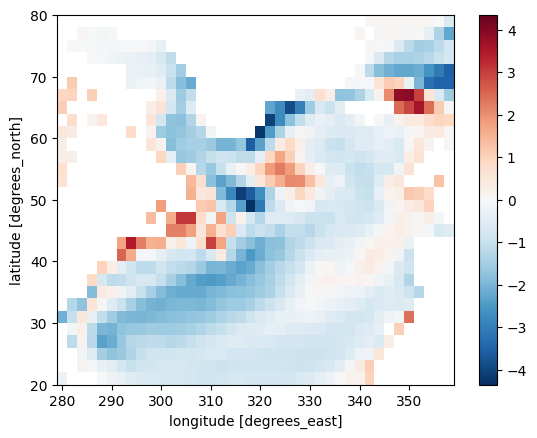

In [100]:
models['ACCESS-CM2']['North Atlantic bias DJF'].plot()

Silhouette coefficient

In [101]:
X = feature_matrix
X.shape

(37, 690)

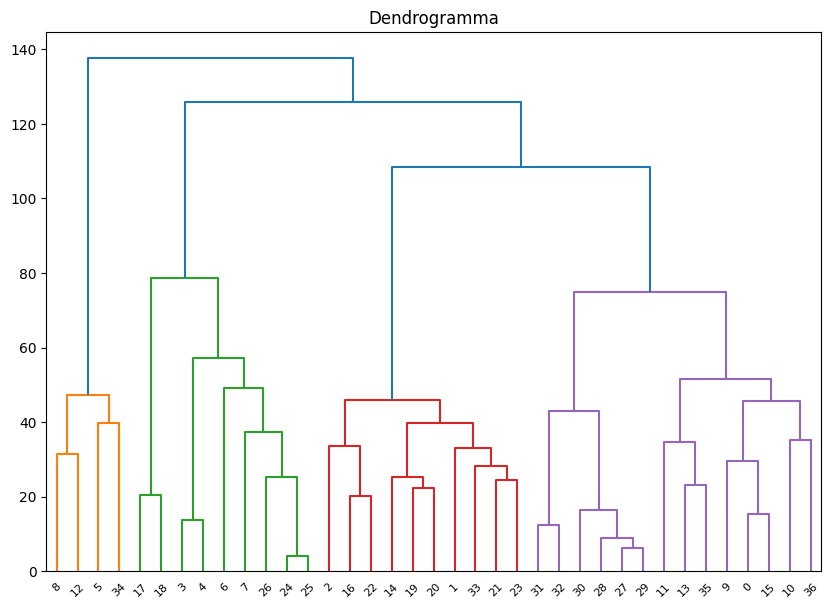

Etichette dei cluster: [31 19 18 32 25 29 35 15 20 21 33 36 27 26 23 24 30 28 34 13 22 12 14  9
 17 16 11  8  7  5  6  3 10  4  1  2  0]


In [102]:
#Hierarchical clustering agglomerative
# Definire il modello di clustering gerarchico
cluster_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(X) #The linkage distance threshold at or above which clusters will not be merged. = 0 ha senso solo se si desidera ottenere un dendrogramma completo, senza effettuare alcuna fusione automatica dei cluster

# Visualizzare il dendrogramma
plt.figure(figsize=(10, 7))
plt.title("Dendrogramma")
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.show()

# Ottenere le etichette dei cluster
cluster_labels = cluster_model.labels_

# Stampare le etichette dei cluster
print("Etichette dei cluster:", cluster_labels)

#asse y distanza tra i cluster, asse x il numero dei cluster


In [103]:
models.keys()

dict_keys(['TaiESM1', 'AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CAS-ESM2-0', 'FGOALS-g3', 'CanESM5', 'CMCC-CM2-SR5', 'ACCESS-ESM1-5', 'ACCESS-CM2', 'E3SM-1-0', 'EC-Earth3', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'MPI-ESM-1-2-HAM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorESM2-LM', 'NorESM2-MM', 'GFDL-ESM4', 'NESM3', 'SAM0-UNICON', 'MCM-UA-1-0'])

Numero di componenti principali: 37
Varianza spiegata cumulativa: [0.35111368 0.5351461  0.69020064 0.76945395 0.81695685 0.84988084
 0.87805375 0.90204997 0.9176053  0.9296143  0.94019679 0.94900325
 0.95573277 0.96184042 0.9675599  0.97168898 0.97546836 0.97881551
 0.98185183 0.98484038 0.98736361 0.98960396 0.99171299 0.99349355
 0.99482781 0.9958484  0.99674729 0.99763671 0.99830377 0.99886424
 0.99927148 0.99957154 0.99979095 0.99990143 0.99996347 1.
 1.        ]


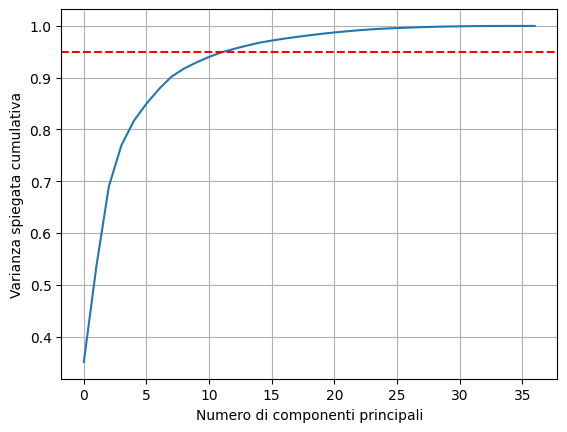

In [104]:
# Applica la PCA
pca = PCA() # se non indico il numero di componenti prende il minimo tra il numero di samples (41) e il numero di features (491)
X_pca = pca.fit_transform(X)

# Numero di componenti principali
num_components = pca.n_components_
print("Numero di componenti principali:", num_components)

# Varianza spiegata cumulativa
explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)
print("Varianza spiegata cumulativa:", explained_variance_ratio_cumulative)

plt.plot(explained_variance_ratio_cumulative)
plt.axhline(y=0.95, color='r', linestyle='--') #retta al 95%
plt.xlabel('Numero di componenti principali')
plt.ylabel('Varianza spiegata cumulativa')
plt.grid(True)
plt.show()

In [105]:
type(X_pca)

numpy.ndarray

In [106]:
pca = PCA(n_components=12)  # n_components = 10 per 95%, n_components = 22 per 99%
X_pca = pca.fit_transform(X)
X_pca.shape

(37, 12)

Capisco se ottengo lo stesso risultato

In [107]:
np.dot(X.T,X) #matrice di covarianza di X, di dim 491x491


array([[19.03549271, 14.94917978, 12.7913597 , ...,  0.39710898,
        -1.41763106, -6.41843973],
       [14.94917978, 17.97126618, 16.75780758, ..., -0.95197273,
        -3.01358847, -3.60538974],
       [12.7913597 , 16.75780758, 17.30151958, ..., -0.59385724,
        -2.71199969, -3.47621917],
       ...,
       [ 0.39710898, -0.95197273, -0.59385724, ...,  2.3270636 ,
         2.80793264,  2.21127195],
       [-1.41763106, -3.01358847, -2.71199969, ...,  2.80793264,
         4.64234103,  6.87326811],
       [-6.41843973, -3.60538974, -3.47621917, ...,  2.21127195,
         6.87326811, 21.74576813]])

In [108]:
pca.singular_values_

array([126.82515252,  91.81818309,  84.27985286,  60.25460237,
        46.64891555,  38.83629216,  35.92504901,  33.15529765,
        26.69446301,  23.45497113,  22.01786769,  20.08536039])

In [109]:
#creo la matrice sigma: matrice diagonale che ha come elementi i singular values
sigma = np.diag(pca.singular_values_)
#sigma

In [110]:
sigma_quadro = np.dot(sigma,sigma)
#sigma_quadro

In [111]:
pca.components_

array([[-1.77020431e-02, -1.56845934e-02, -1.44621291e-02, ...,
        -2.80072228e-06,  8.96096901e-04,  3.28176967e-03],
       [-8.33715248e-03,  1.76300101e-03, -5.46581390e-04, ...,
        -3.12242481e-03, -4.73019025e-03, -8.97748617e-03],
       [ 2.32115957e-02,  2.30337995e-02,  2.40442201e-02, ...,
         1.94212435e-04, -5.49331205e-03, -2.21070368e-02],
       ...,
       [-1.82860713e-02, -1.25626714e-02, -7.37266487e-04, ...,
         2.94968660e-02,  4.27304577e-02,  7.04729842e-02],
       [ 3.66322323e-02,  8.20729407e-03,  5.97530103e-03, ...,
         1.12926836e-02,  1.71069454e-02,  3.00413223e-02],
       [-4.73032374e-02, -3.72457093e-02, -1.37109673e-02, ...,
         1.78398765e-02,  8.69112370e-03, -1.12857526e-02]])

In [112]:
(pca.components_).shape #the directions of maximum variance (the principal components)
#pca.components_ #sono i right singular vectors

(12, 690)

In [113]:
# X.T * X = V * sigma_quadro * V.T, dove V.T = pca.components_
#calcolo V*sigma_quadro
v_sigma_quadro = np.dot((pca.components_).T,sigma_quadro)
matr_cov_X = np.dot(v_sigma_quadro,pca.components_)
matr_cov_X #quindi non stessa matrice di partenza

array([[ 1.46705696e+01,  1.18910030e+01,  1.12741779e+01, ...,
         1.22876122e-02, -2.13443432e+00, -7.48013835e+00],
       [ 1.18910030e+01,  1.15023956e+01,  1.13862372e+01, ...,
        -8.36934100e-02, -2.01751574e+00, -6.92559959e+00],
       [ 1.12741779e+01,  1.13862372e+01,  1.22272690e+01, ...,
         2.07309142e-01, -1.73124016e+00, -6.63171109e+00],
       ...,
       [ 1.22876122e-02, -8.36934100e-02,  2.07309142e-01, ...,
         1.10924478e+00,  1.37620492e+00,  2.04737251e+00],
       [-2.13443432e+00, -2.01751574e+00, -1.73124016e+00, ...,
         1.37620492e+00,  2.60624324e+00,  5.54739833e+00],
       [-7.48013835e+00, -6.92559959e+00, -6.63171109e+00, ...,
         2.04737251e+00,  5.54739833e+00,  1.40360904e+01]])

Con la PCA (che usa SVD) si riottiene un'approssimazione migliore possibile dei dati di partenza

In [114]:
#prendo la prima delle 10 componenti, quella che descrive il 44% della varianza
pca.components_[0]

array([-1.77020431e-02, -1.56845934e-02, -1.44621291e-02, -1.43868211e-02,
       -1.48621859e-02, -1.50503637e-02, -1.51183014e-02, -1.52938511e-02,
       -1.59760039e-02, -1.64790268e-02, -1.70000758e-02, -1.75412545e-02,
       -1.75090941e-02, -1.74744409e-02, -1.75949968e-02, -1.80651954e-02,
       -1.82930884e-02, -1.81329375e-02, -1.84510170e-02, -1.88003690e-02,
       -1.84078915e-02, -1.86423077e-02, -1.96581103e-02, -2.16544596e-02,
       -2.39020954e-02, -2.64906176e-02, -3.00634581e-02, -3.62291118e-02,
       -1.65493159e-02, -1.58284945e-02, -1.57682157e-02, -1.52189338e-02,
       -1.46704506e-02, -1.41106009e-02, -1.38412745e-02, -1.41031498e-02,
       -1.42685990e-02, -1.45671261e-02, -1.49202675e-02, -1.50739914e-02,
       -1.52292878e-02, -1.53198108e-02, -1.54019158e-02, -1.60112512e-02,
       -1.67804344e-02, -1.67587591e-02, -1.68866231e-02, -1.79485597e-02,
       -1.86375690e-02, -1.86207343e-02, -1.88947605e-02, -2.00475948e-02,
       -2.15471594e-02, -

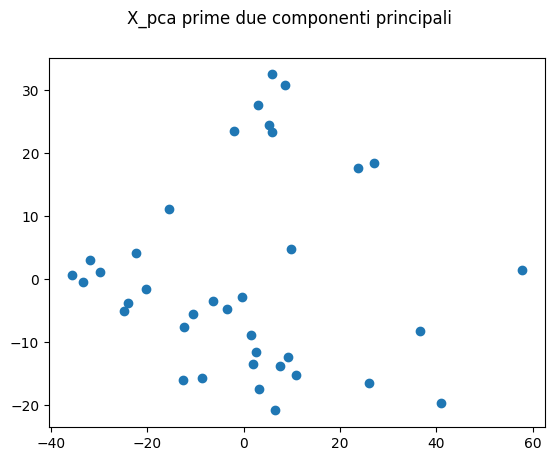

In [115]:
#plotto sulle prime due componenti principali X_pca
pca = PCA(n_components=2)  # n_components = 10 per 95%, n_components = 22 per 99%
X_pca2_plot = pca.fit_transform(X) #41x2
pl.scatter(X_pca2_plot[:, 0], X_pca2_plot[:, 1]) #plotto prima tutte le righe della prima colonna di X_pca_plot e poi tutte le righe della seconda colonna
plt.suptitle('X_pca prime due componenti principali')
plt.show()

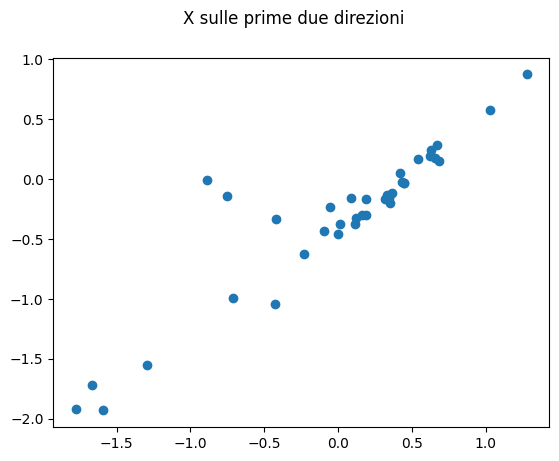

In [116]:
#plot X sulle prime due direzioni
pl.scatter(X[:,0], X[:,1])
plt.suptitle('X sulle prime due direzioni')
plt.show()

In [117]:
#provo a plottare in 3d X_pca
pca = PCA(n_components=3)
X_pca3_plot = pca.fit_transform(X)

px.scatter_3d(
    X_pca3_plot, x=0, y=1, z=2,
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    title='X_pca prime 3 componenti principali'
)

In [118]:
#provo a plottare in 3d X

px.scatter_3d(
    X, x=0, y=1, z=2,
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    title='X prime 3 direzioni'
)

In [119]:
X

array([[ 3.29072952e-01, -1.31599426e-01, -1.73906326e-01, ...,
         2.78654099e-02, -1.29621029e-02, -5.78244090e-01],
       [ 3.16402435e-01, -1.69565201e-01, -2.07162857e-01, ...,
         1.93054914e-01,  8.26535821e-01,  1.87461245e+00],
       [-1.29308319e+00, -1.55160904e+00, -1.31103325e+00, ...,
         5.44675469e-01,  1.32632184e+00,  2.55702066e+00],
       ...,
       [-1.77512169e+00, -1.92244911e+00, -1.24360657e+00, ...,
         2.58086920e-02, -3.39351892e-02, -6.41365647e-01],
       [-9.58003998e-02, -4.34276581e-01, -4.17564392e-01, ...,
         1.85334682e-03, -5.86756468e-02, -6.57699347e-01],
       [ 1.27907372e+00,  8.74612808e-01,  8.33702087e-01, ...,
        -5.99174500e-02, -4.07512188e-02, -5.07833838e-01]])

In [120]:
X_pca

array([[-2.47890439e+01, -5.10348824e+00,  6.29371215e+00,
         9.18882428e+00, -3.32931039e+00, -3.40839940e+00,
        -1.45690991e+00, -5.63792866e+00,  7.08828915e-01,
         2.37696769e+00, -4.04033705e+00,  3.28855435e+00],
       [-1.04475778e+01, -5.54001925e+00, -1.18895443e+01,
        -9.34728819e+00,  3.99036992e+00,  8.41133783e+00,
         1.39686729e+01, -4.21601658e+00, -4.87665592e+00,
         2.11411293e+00, -3.10818263e+00,  3.32986855e+00],
       [ 1.08472785e+01, -1.52955482e+01, -2.07720053e+01,
         8.42120242e+00, -3.15748493e+00,  1.00126018e+01,
        -6.87566921e+00,  3.10902573e+00, -8.27410359e+00,
         1.06201967e+01,  2.82981879e+00, -6.36471872e+00],
       [ 8.52913418e+00,  3.08924918e+01,  9.57628189e+00,
        -1.81918929e+00,  1.05489705e+01,  1.56284246e+01,
        -4.54579570e+00, -2.66882790e+00,  1.42002575e+00,
        -6.91282092e-01, -4.39629778e+00,  1.79112492e+00],
       [ 5.90162701e+00,  3.25238895e+01,  3.5854554

In [121]:
X_pca.shape

(37, 12)

5 cluster

iteration number 0 max_sil_avg =  -1
iteration number 0 max_sil_avg =  0.2746681082370877


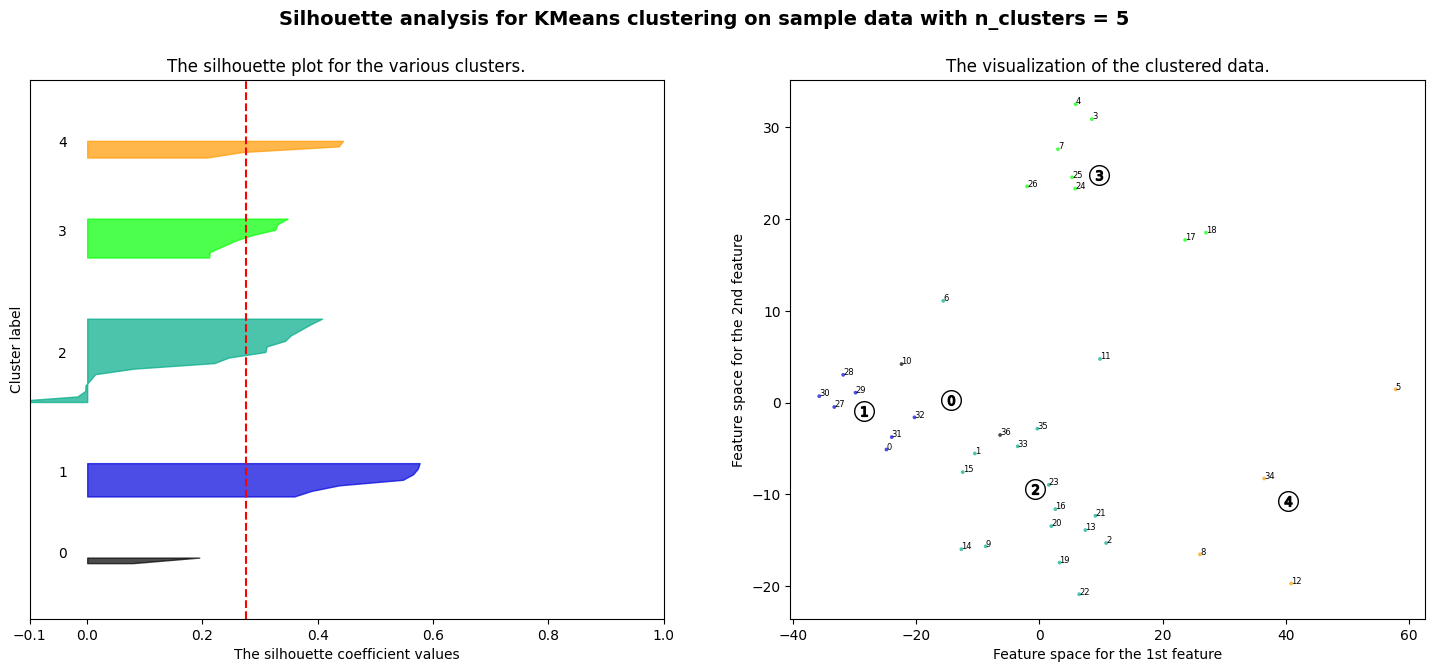

iteration number 1 max_sil_avg =  0.3231766776170452


<Figure size 640x480 with 0 Axes>

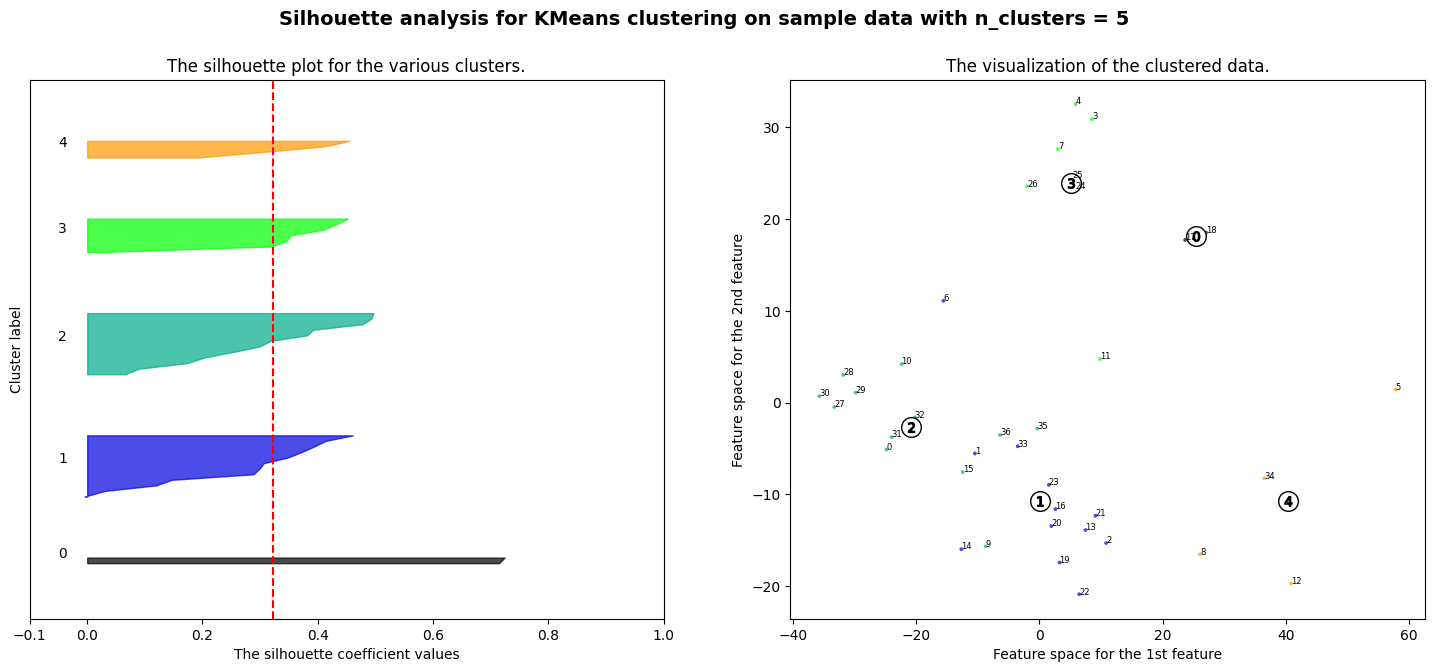

iteration number 5 max_sil_avg =  0.3239155145252011


<Figure size 640x480 with 0 Axes>

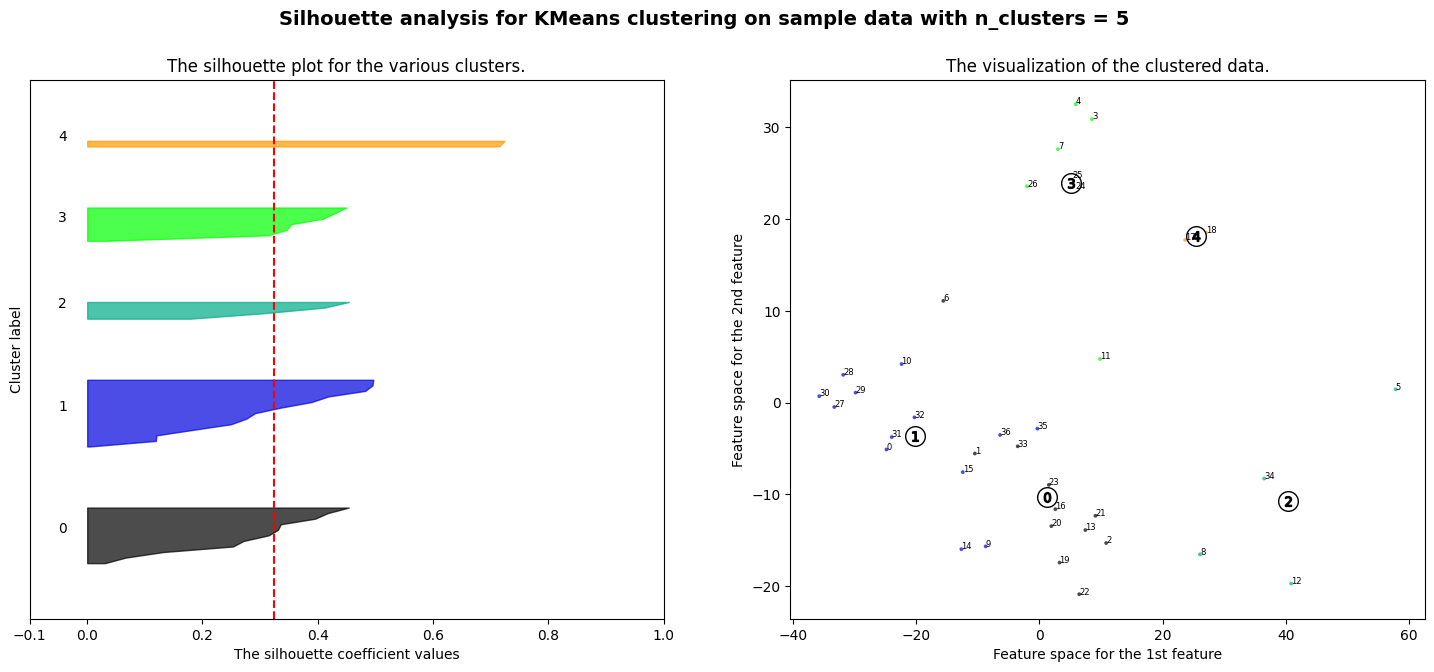

iteration number 9 max_sil_avg =  0.3239155145252011


<Figure size 640x480 with 0 Axes>

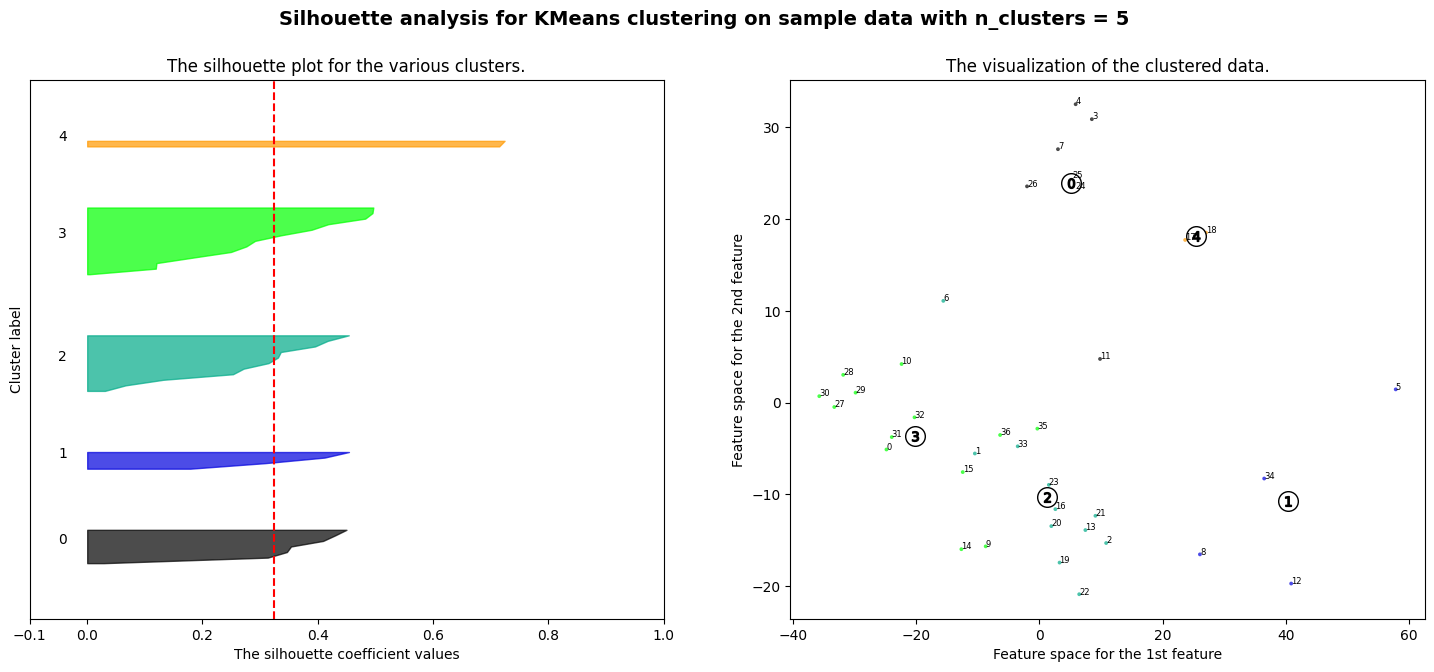

iteration number 10 max_sil_avg =  0.3239155145252011


<Figure size 640x480 with 0 Axes>

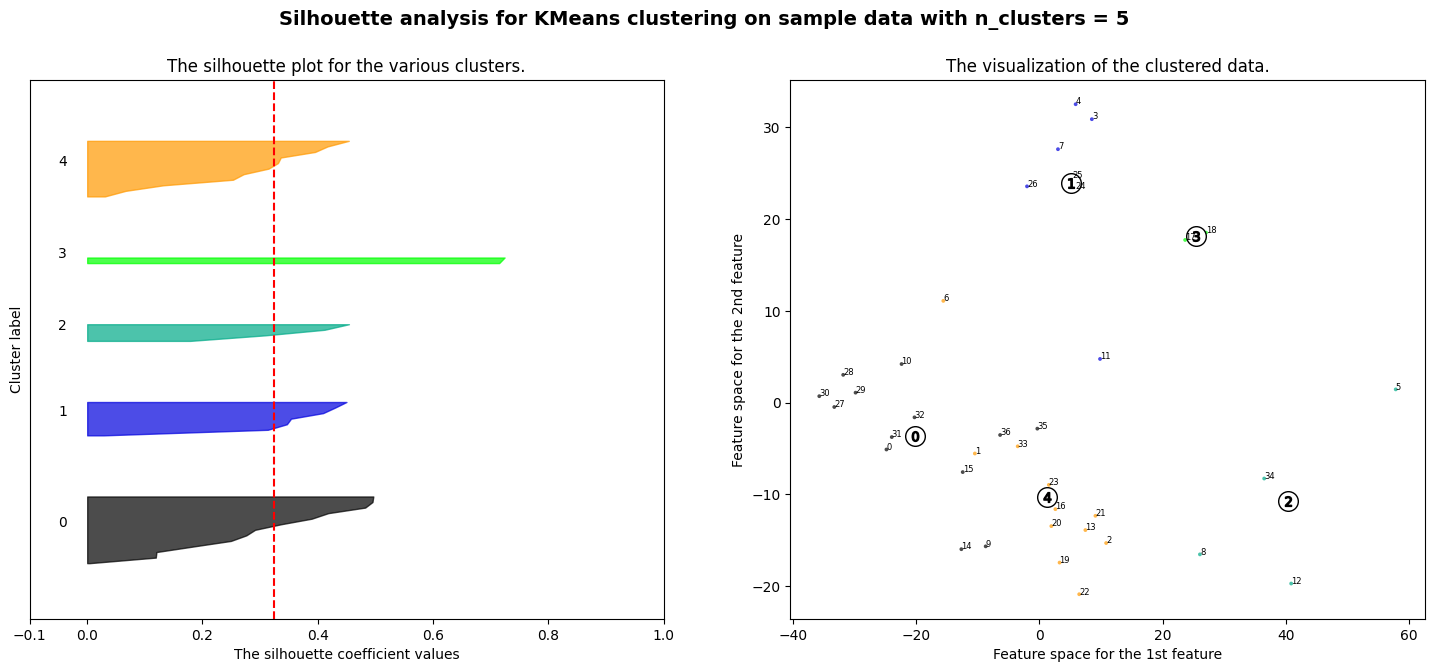

iteration number 20 max_sil_avg =  0.3239155145252011


<Figure size 640x480 with 0 Axes>

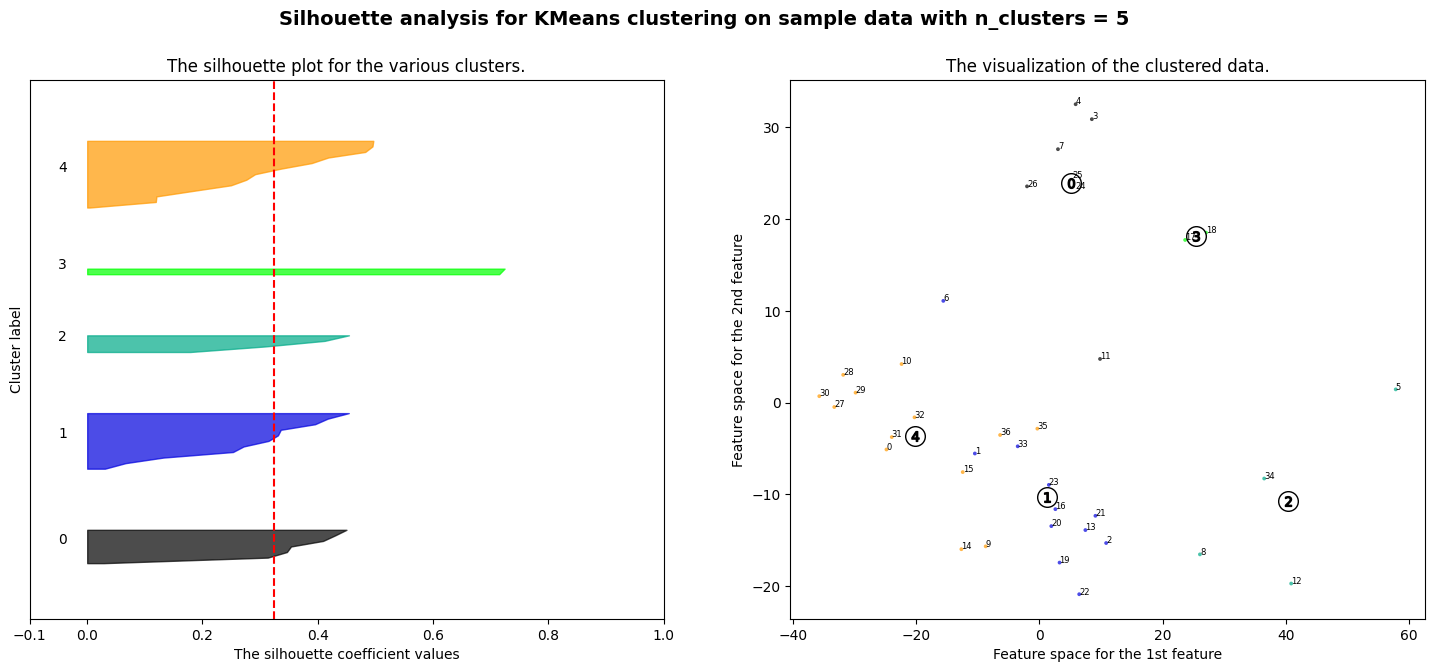

iteration number 23 max_sil_avg =  0.3239155145252011


<Figure size 640x480 with 0 Axes>

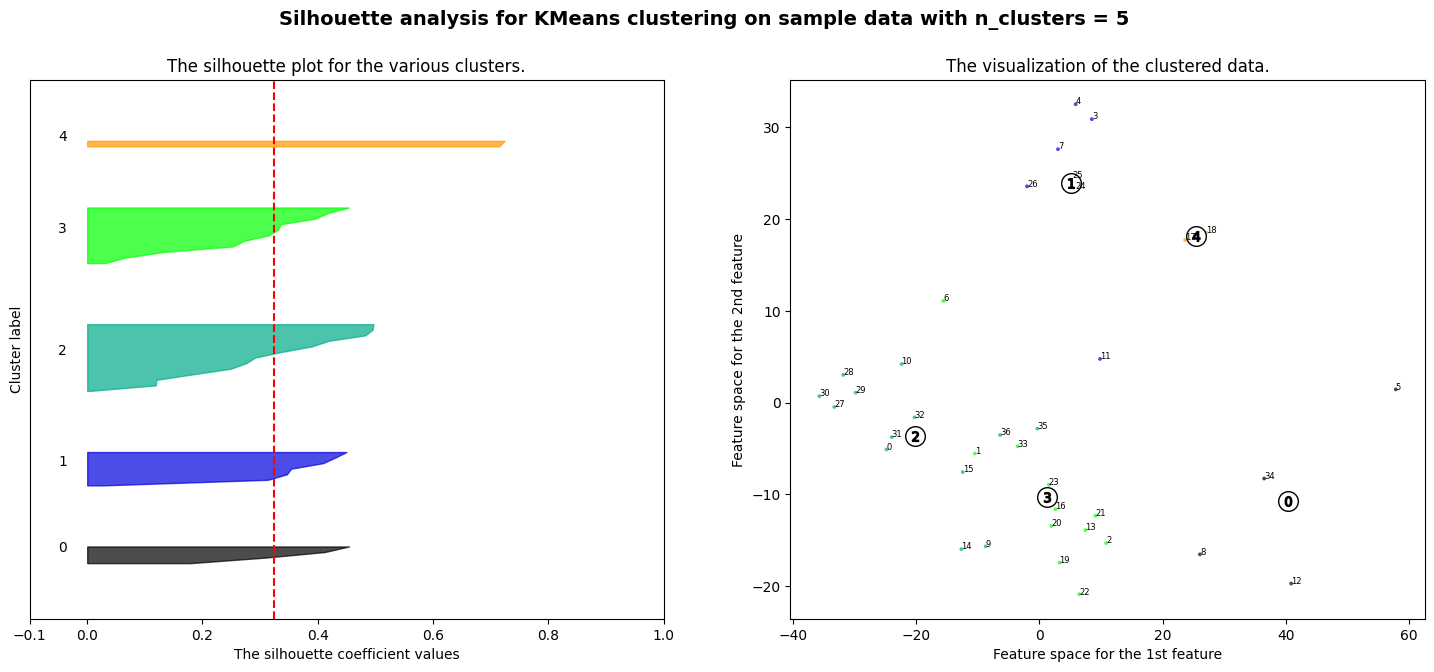

iteration number 52 max_sil_avg =  0.3239155145252011


<Figure size 640x480 with 0 Axes>

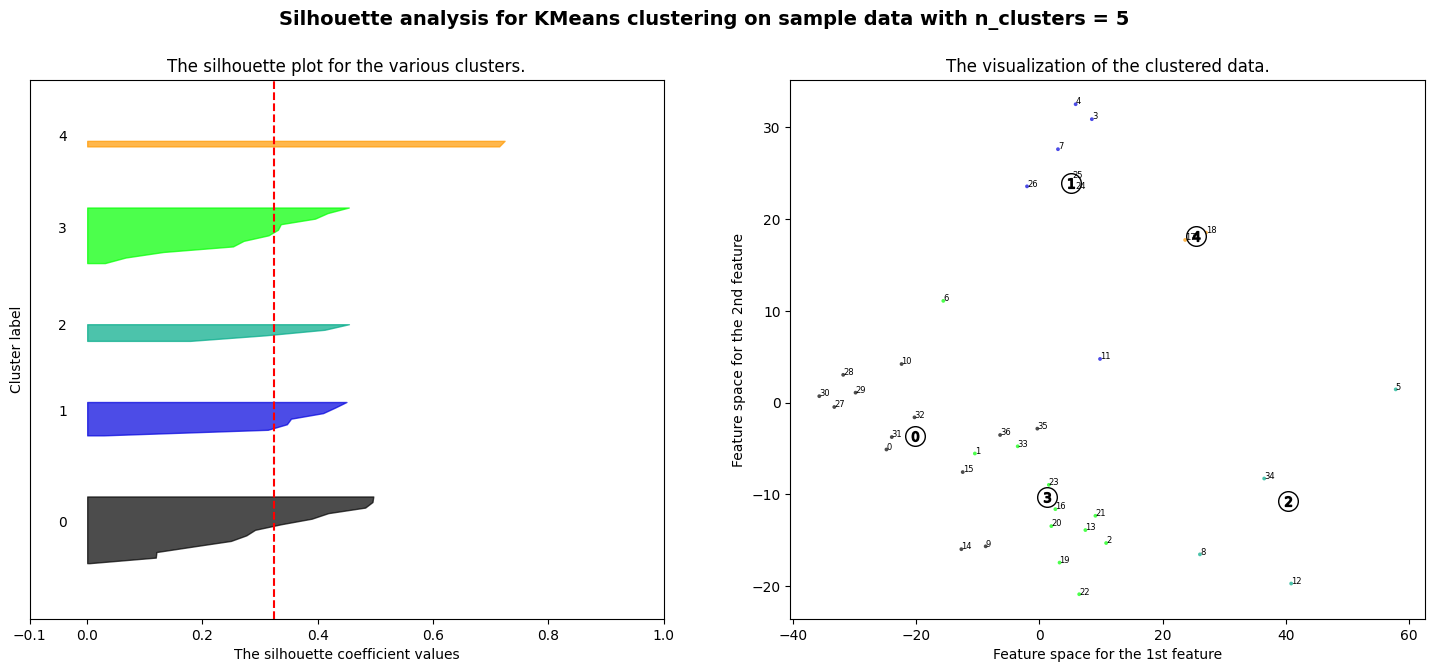

iteration number 55 max_sil_avg =  0.3239155145252011


<Figure size 640x480 with 0 Axes>

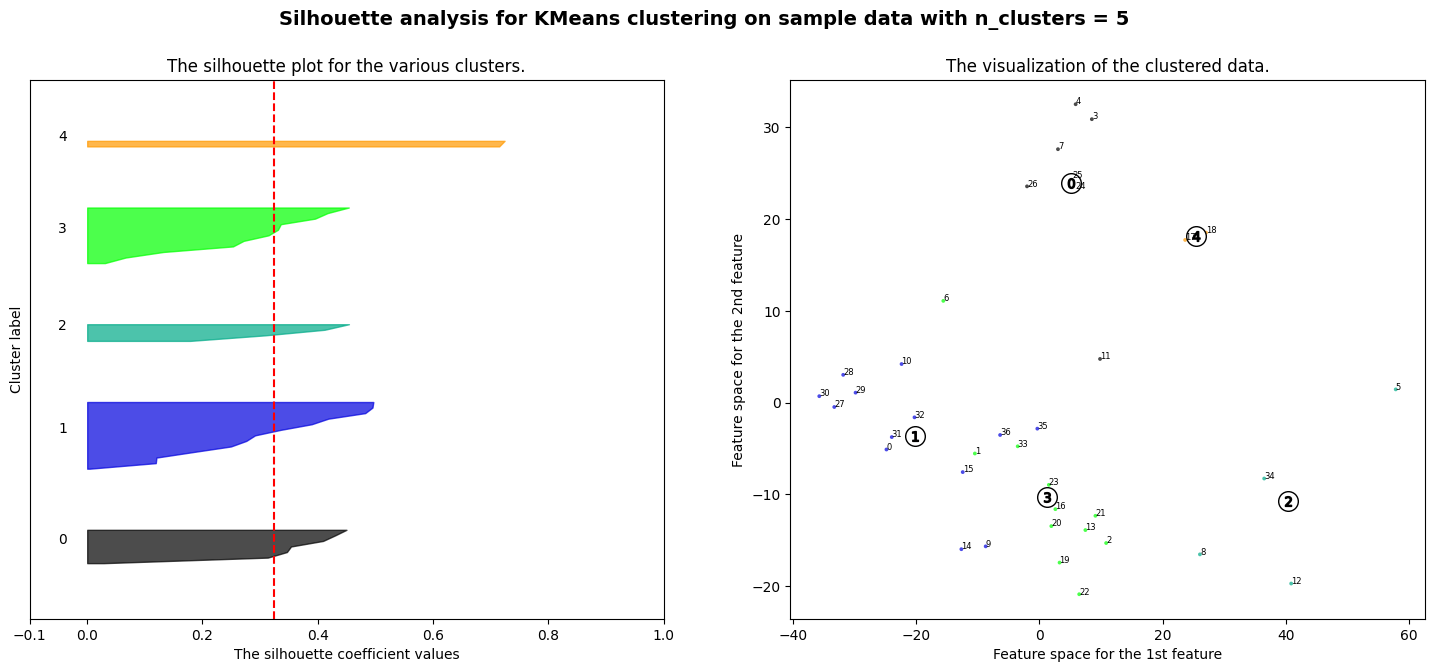

iteration number 58 max_sil_avg =  0.3239155145252011


<Figure size 640x480 with 0 Axes>

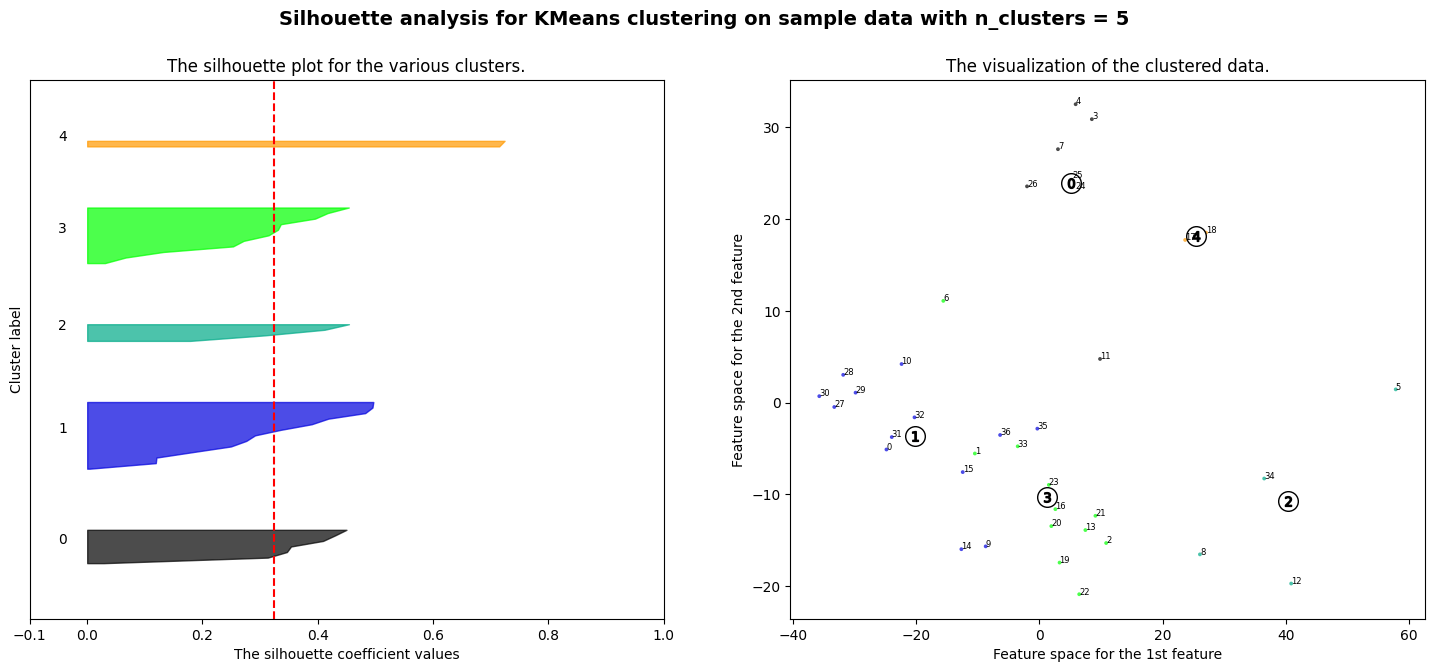

iteration number 66 max_sil_avg =  0.3239155145252011


<Figure size 640x480 with 0 Axes>

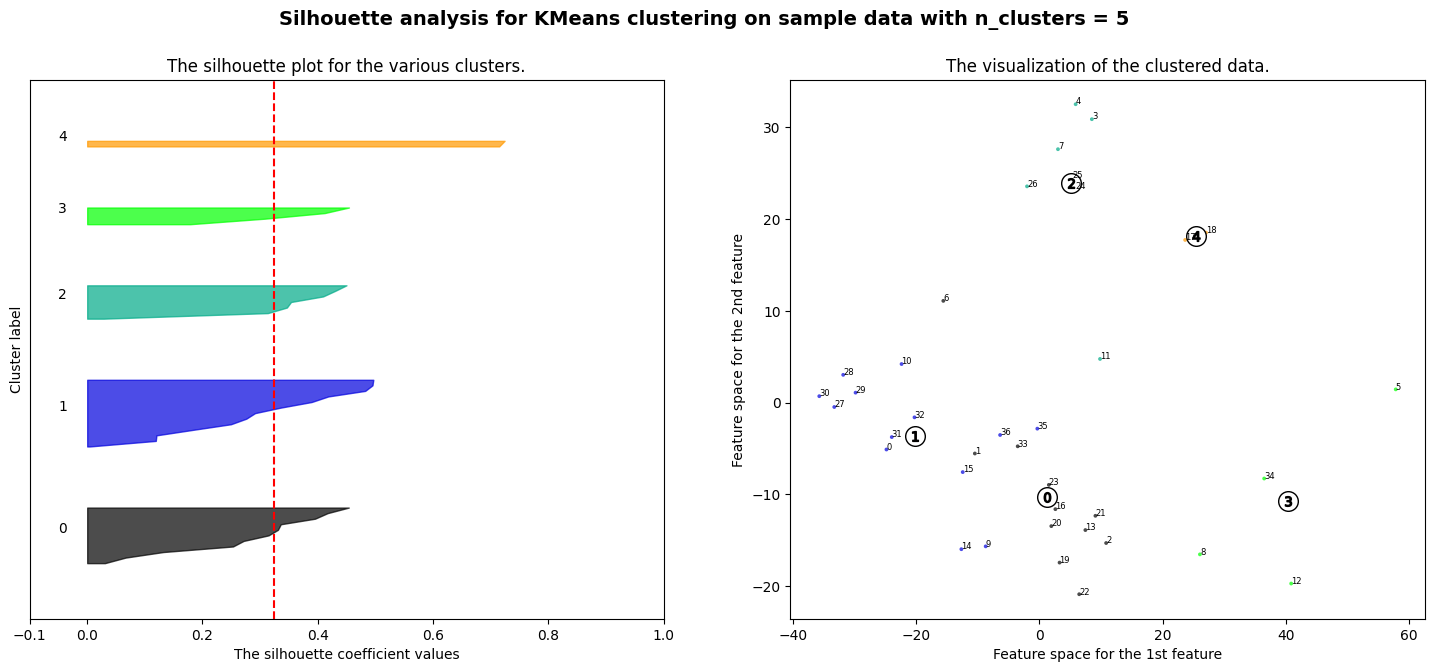

iteration number 76 max_sil_avg =  0.3239155145252011


<Figure size 640x480 with 0 Axes>

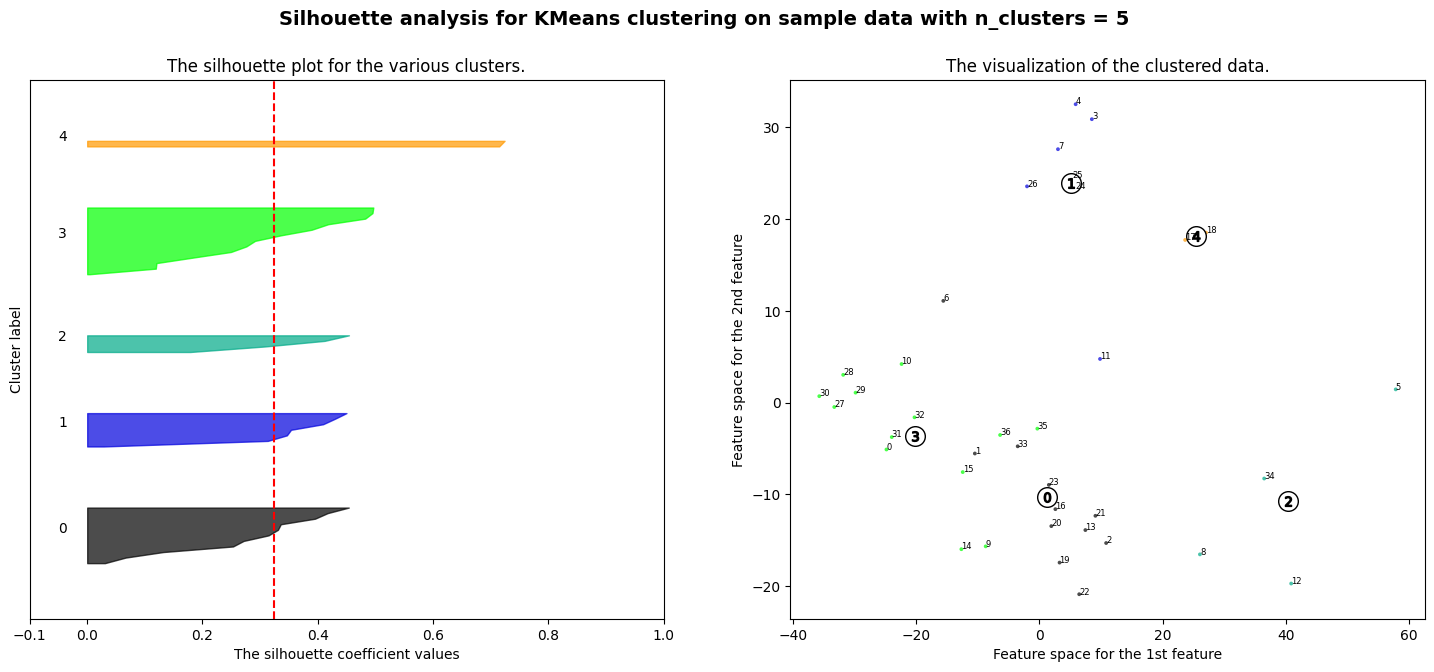

iteration number 96 max_sil_avg =  0.3239155145252011


<Figure size 640x480 with 0 Axes>

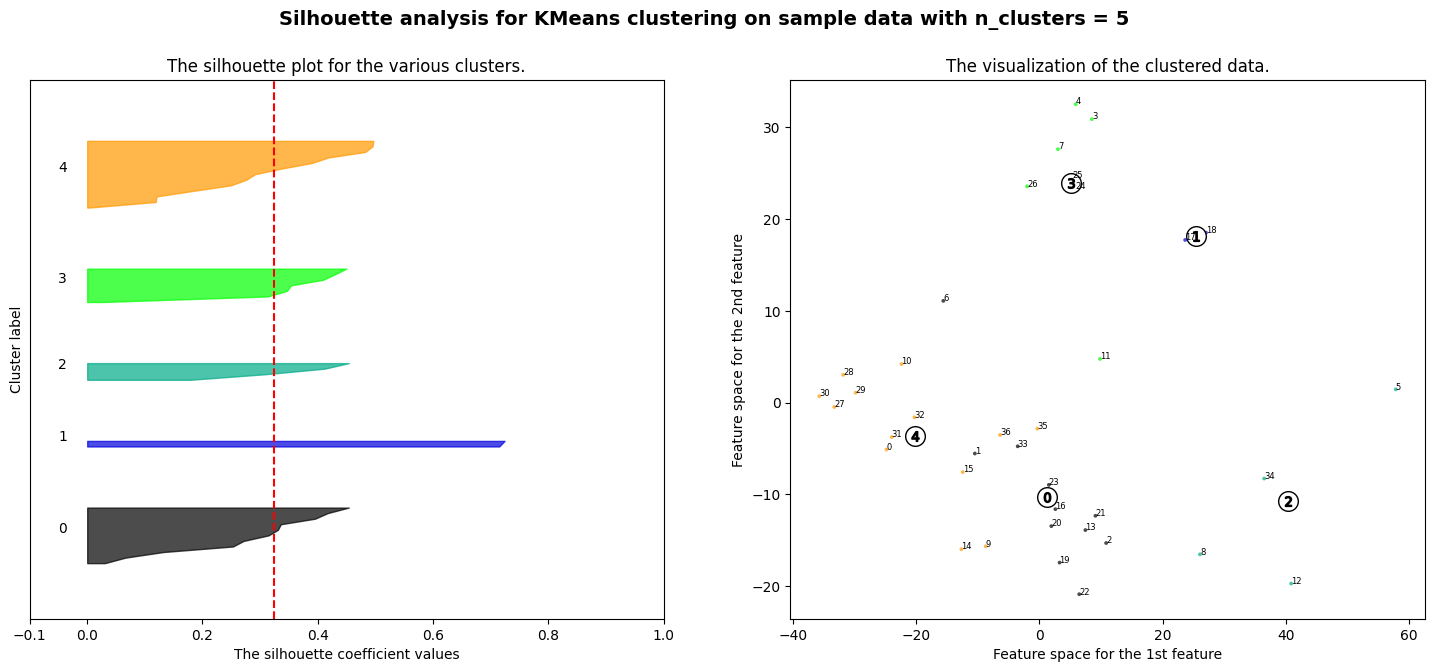

<Figure size 640x480 with 0 Axes>

In [122]:
#100 iterazioni, con X_pca

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
#X = feature_matrix
range_n_clusters = [2, 3, 4, 5, 6, 7]

 #Indici per il conteggio di quante volte è comparso un valore negativo, dopo 100 iterazioni
i = 0 #2 cluster
j = 0 #3 cluster
k = 0 #4 cluster
l = 0 #5 cluster
m = 0 #6 cluster
n = 0 #7 cluster
#Valori per il calcolo della media di silhouette_avg
a = 0
b = 0
c = 0
d = 0
e = 0
f = 0
#Inizializzo il vettore in cui andrò a mettere tutti i silhouette_avg
iterations = 100
sil_avg_pca = np.zeros(iterations) #dimensioni pari al numero di iterazioni
labels_pca = np.zeros(len(X_pca)) #41 pari al numero di modelli
centroids_pca = np.zeros((range_n_clusters[3],len(X_pca.T))) #4x10
max_sil_avg_pca = -1
#Inizializzo un vettore che ha indice pari al valore delle righe, in modo tale da individuare ogni modello all'interno del plot
index_models_pca = np.arange(len(X_pca))# [0,1,2,...,40]

#100 iterazioni
for p in range(iterations):
    
    for n_clusters in range_n_clusters:

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters,init='k-means++') # k-means++ per inizializzare i centroid + distanti iin modo da evitare i minimi locali
        cluster_labels = clusterer.fit_predict(X_pca)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X_pca, cluster_labels) #il valore medio del silhouette score tra tutti i cluster
    #    print(
    #        "For n_clusters =",
    #        n_clusters,
    #        "The average silhouette_score is :",
    #        silhouette_avg,
    #    )

        #aggiorno i valori per poi calcolare la media di silhouette_avg
        if n_clusters == range_n_clusters[0]: #2 cluster
            a = a + silhouette_avg
        elif n_clusters == range_n_clusters[1]: #3 cluster
            b = b + silhouette_avg
        elif n_clusters == range_n_clusters[2]: #4 cluster
            c = c + silhouette_avg
        elif n_clusters == range_n_clusters[3]: #5 cluster
            d = d + silhouette_avg
            #Prendo il silhouette_avg maggiore (lo faccio solo per 4 cluster) e fisso i labels e i centers
            #Inserisco silhouette_avg in un vettore
            sil_avg_pca[p] = silhouette_avg
            if p == 0: #primo elemento dell'array sil_avg
                max_sil_avg = sil_avg_pca[p] #fisso il primo come il massimo 
                print("iteration number",p,"max_sil_avg = ",max_sil_avg_pca)         
            if sil_avg_pca[p] >= max_sil_avg_pca: # scelgo il silh. coefficient maggiore e salvo i labels e i centroids. L'uguale è per p==0
                fig.clf() #elimino il grafico pre-esistente
                labels_pca = clusterer.labels_ #labels
                centroids_pca = clusterer.cluster_centers_ #centroids 
                max_sil_avg_pca = sil_avg_pca[p] # il p-esimo elemento di sil_avg diventa il massimo valore di silhouette coefficient
                print("iteration number",p,"max_sil_avg = ",max_sil_avg_pca)

                #plot del silhouette coefficient
                #assi per il plot
                fig, (ax1, ax2) = plt.subplots(1, 2)
                fig.set_size_inches(18,7)

                # The 1st subplot is the silhouette plot
                # The silhouette coefficient can range from -1, 1 but in this example all
                # lie within [-0.1, 1]
                ax1.set_xlim([-0.1, 1])
                # The (n_clusters+1)*10 is for inserting blank space between silhouette
                # plots of individual clusters, to demarcate them clearly.
                ax1.set_ylim([0, len(X_pca) + (5 + 1) * 10]) #dove 4 = n_clusters perché il plot lo faccio solo per 4 clusters

                # The 1st subplot is the silhouette plot
                # The silhouette coefficient can range from -1, 1 but in this example all
                # lie within [-0.1, 1]
                ax1.set_xlim([-0.1, 1])
                # The (n_clusters+1)*10 is for inserting blank space between silhouette
                # plots of individual clusters, to demarcate them clearly.
                ax1.set_ylim([0, len(X_pca) + (5 + 1) * 10]) # len(X) = numero di modelli e quindi il numero di samples. 4 = n_clusters perché il plot lo faccio solo per 4 clusters

                # Compute the silhouette scores for each sample
                sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)
                
                y_lower = 10
                for i in range(n_clusters):
                    # Aggregate the silhouette scores for samples belonging to
                    # cluster i, and sort them
                    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

                    ith_cluster_silhouette_values.sort()

                    size_cluster_i = ith_cluster_silhouette_values.shape[0]
                    y_upper = y_lower + size_cluster_i

                    color = cm.nipy_spectral(float(i) / n_clusters)
                    ax1.fill_betweenx(
                        np.arange(y_lower, y_upper),
                        0,
                        ith_cluster_silhouette_values,
                        facecolor=color,
                        edgecolor=color,
                        alpha=0.7,
                    )

                    # Label the silhouette plots with their cluster numbers at the middle
                    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                    # Compute the new y_lower for next plot
                    y_lower = y_upper + 10  # 10 for the 0 samples

                ax1.set_title("The silhouette plot for the various clusters.")
                ax1.set_xlabel("The silhouette coefficient values")
                ax1.set_ylabel("Cluster label")

                # The vertical line for average silhouette score of all the values
                ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

                ax1.set_yticks([])  # Clear the yaxis labels / ticks
                ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

                # 2nd Plot showing the actual clusters formed
                colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
                ax2.scatter(
                    X_pca[:, 0], X_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
                )
                # Annotazione dei numeri degli indici
                for i, txt in enumerate(index_models_pca):
                    ax2.annotate(txt, (X_pca[i, 0], X_pca[i, 1]), fontsize=6)

                # Draw white circles at cluster centers
                ax2.scatter(
                    centroids_pca[:, 0],
                    centroids_pca[:, 1],
                    marker="o",
                    c="white",
                    alpha=1,
                    s=200,
                    edgecolor="k",
                )

                for i, c in enumerate(centroids_pca):
                    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

                ax2.set_title("The visualization of the clustered data.")
                ax2.set_xlabel("Feature space for the 1st feature")
                ax2.set_ylabel("Feature space for the 2nd feature")

                plt.suptitle(
                    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
                    % n_clusters,
                    fontsize=14,
                    fontweight="bold",
                )

                plt.show()
                plt.savefig('sil_coeff_X_pca.pdf', format='pdf')


        elif n_clusters == range_n_clusters[4]: #6 cluster
            e = e + silhouette_avg  
        elif n_clusters == range_n_clusters[5]: #7 cluster
            f = f + silhouette_avg

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)
    
        if np.any(sample_silhouette_values < 0):
            #print("For n_clusters =", n_clusters, "there are negative silhouette values.") #Se almeno uno dei samples ha sil coeff < 0
            #Aggiorno il conteggio quando ho un valore dei coefficienti negativo per ogni iterazione
            if n_clusters == range_n_clusters[0]:
                i = i + 1
            elif n_clusters == range_n_clusters[1]:
                j = j + 1
            elif n_clusters == range_n_clusters[2]:
                k = k + 1
            elif n_clusters == range_n_clusters[3]:
                l = l + 1
            elif n_clusters == range_n_clusters[4]:
                m = m + 1  
            elif n_clusters == range_n_clusters[5]:
                n = n + 1

cluster_2_mean = a / iterations
cluster_3_mean = b / iterations
cluster_4_mean = c / iterations
cluster_5_mean = d / iterations
cluster_6_mean = e / iterations
cluster_7_mean = f / iterations

#print("n_clusters = ", range_n_clusters[0], "has", i, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_2_mean)
#print("n_clusters = ", range_n_clusters[1], "has", j, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_3_mean)
#print("n_clusters = ", range_n_clusters[2], "has", k, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_4_mean)
#print("n_clusters = ", range_n_clusters[3], "has", l, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_5_mean)
#print("n_clusters = ", range_n_clusters[4], "has", m, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_6_mean)
#print("n_clusters = ", range_n_clusters[5], "has", n, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_7_mean)


In [123]:
labels_pca

array([4, 0, 0, 3, 3, 2, 0, 3, 2, 4, 4, 3, 2, 0, 4, 4, 0, 1, 1, 0, 0, 0,
       0, 0, 3, 3, 3, 4, 4, 4, 4, 4, 4, 0, 2, 4, 4], dtype=int32)

iteration number 0 max_sil_avg =  0.20270868563523056
iteration number 0 max_sil_avg =  0.20270868563523056


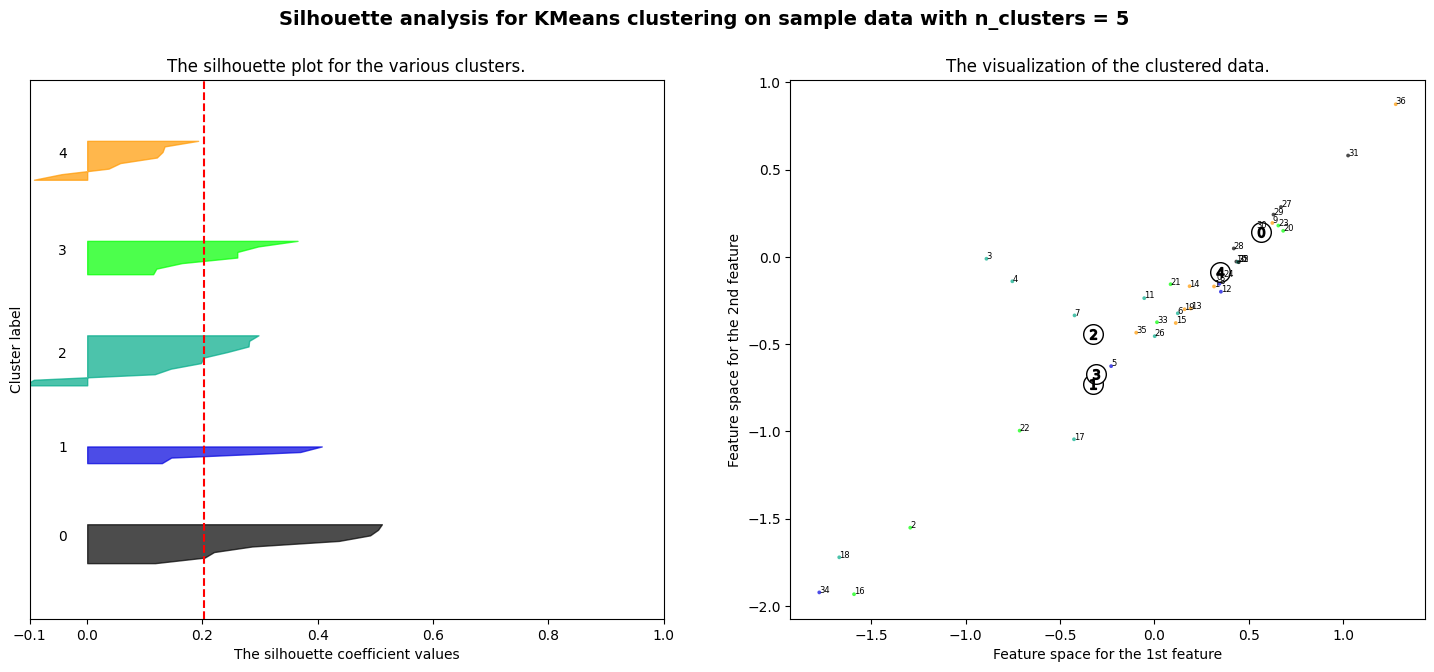

iteration number 2 max_sil_avg =  0.2378386120098829


<Figure size 640x480 with 0 Axes>

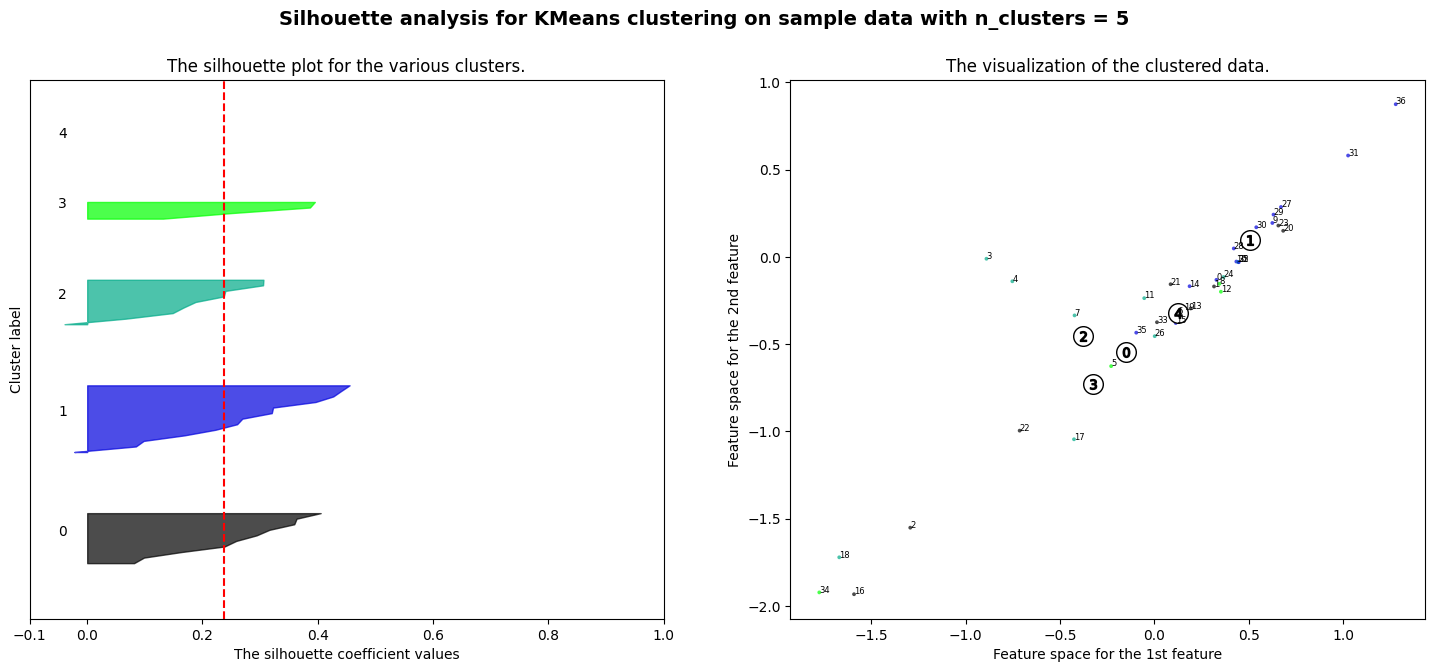

iteration number 4 max_sil_avg =  0.24012192624052836


<Figure size 640x480 with 0 Axes>

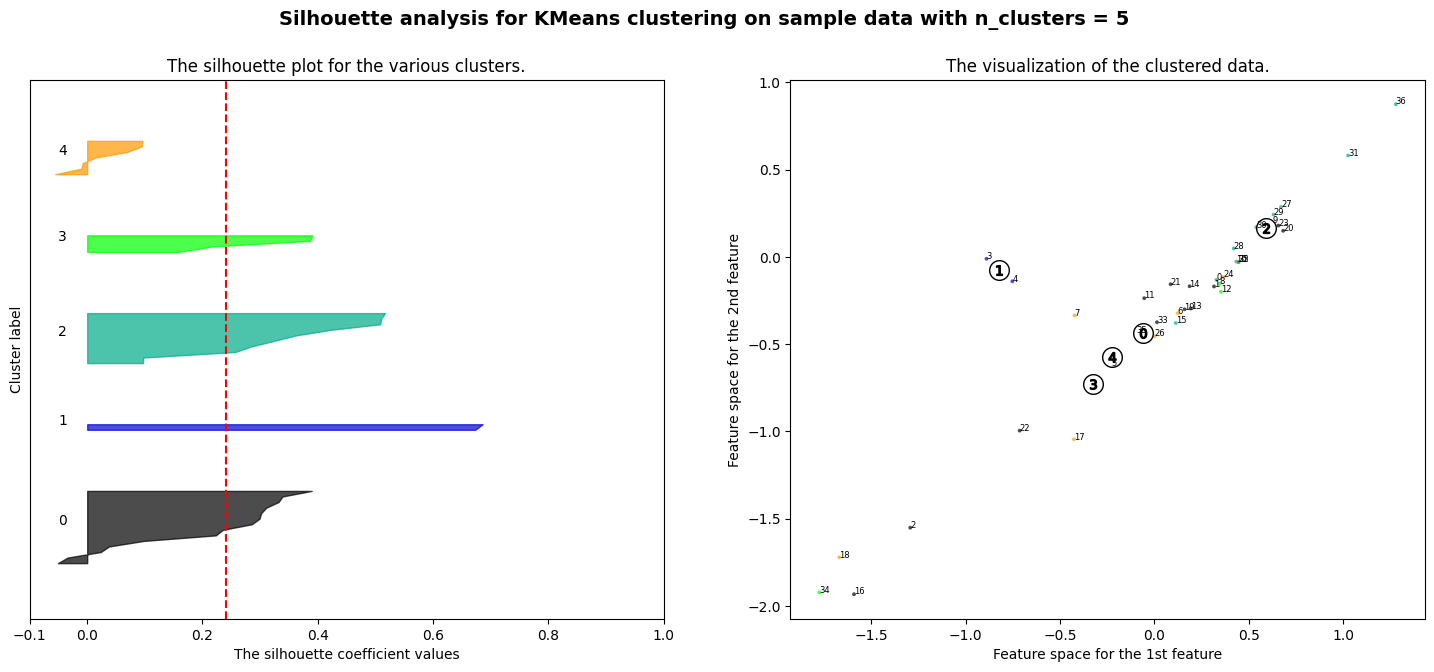

iteration number 5 max_sil_avg =  0.2842180996494318


<Figure size 640x480 with 0 Axes>

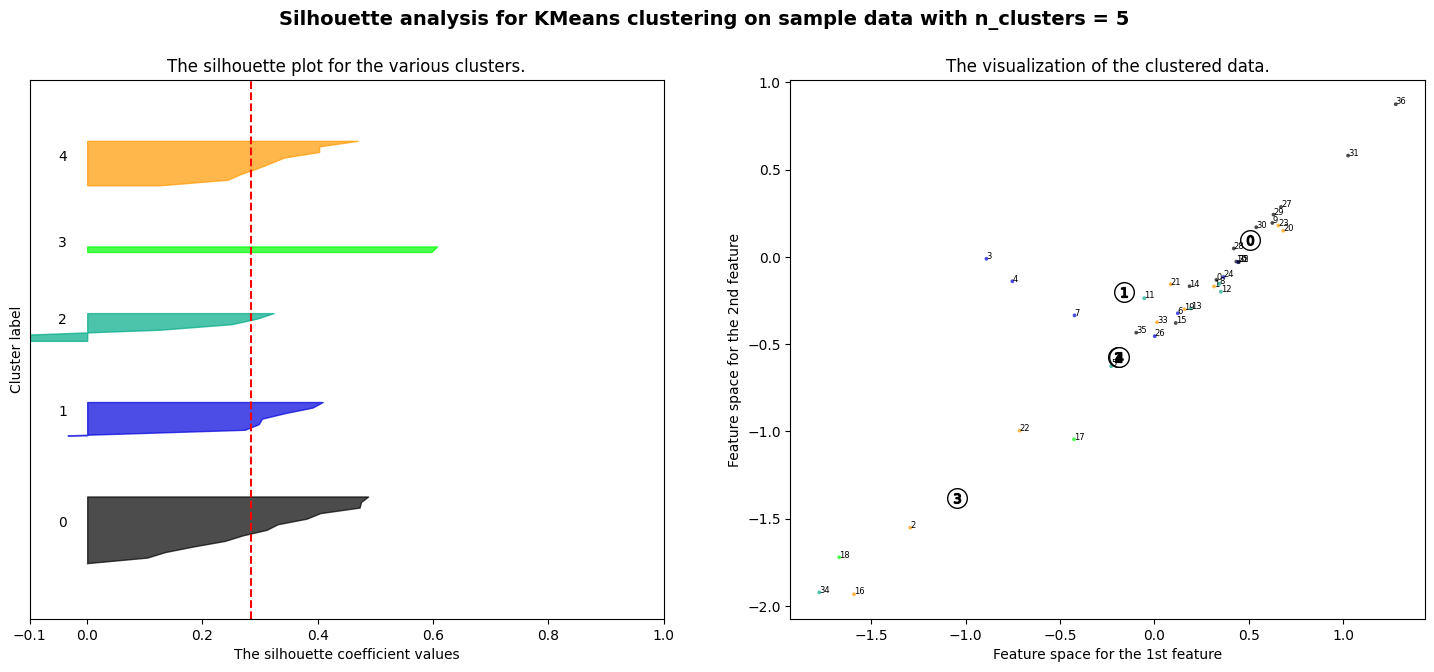

iteration number 13 max_sil_avg =  0.2942367382615611


<Figure size 640x480 with 0 Axes>

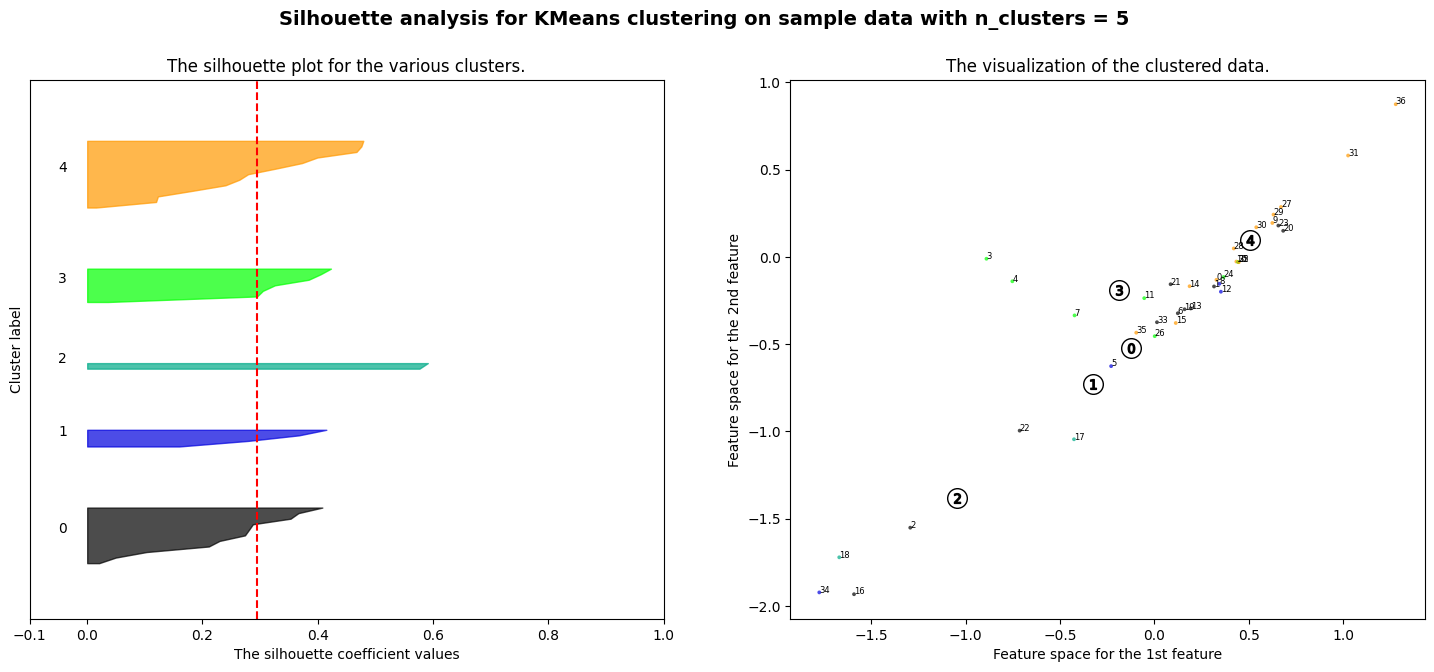

iteration number 82 max_sil_avg =  0.2942367382615611


<Figure size 640x480 with 0 Axes>

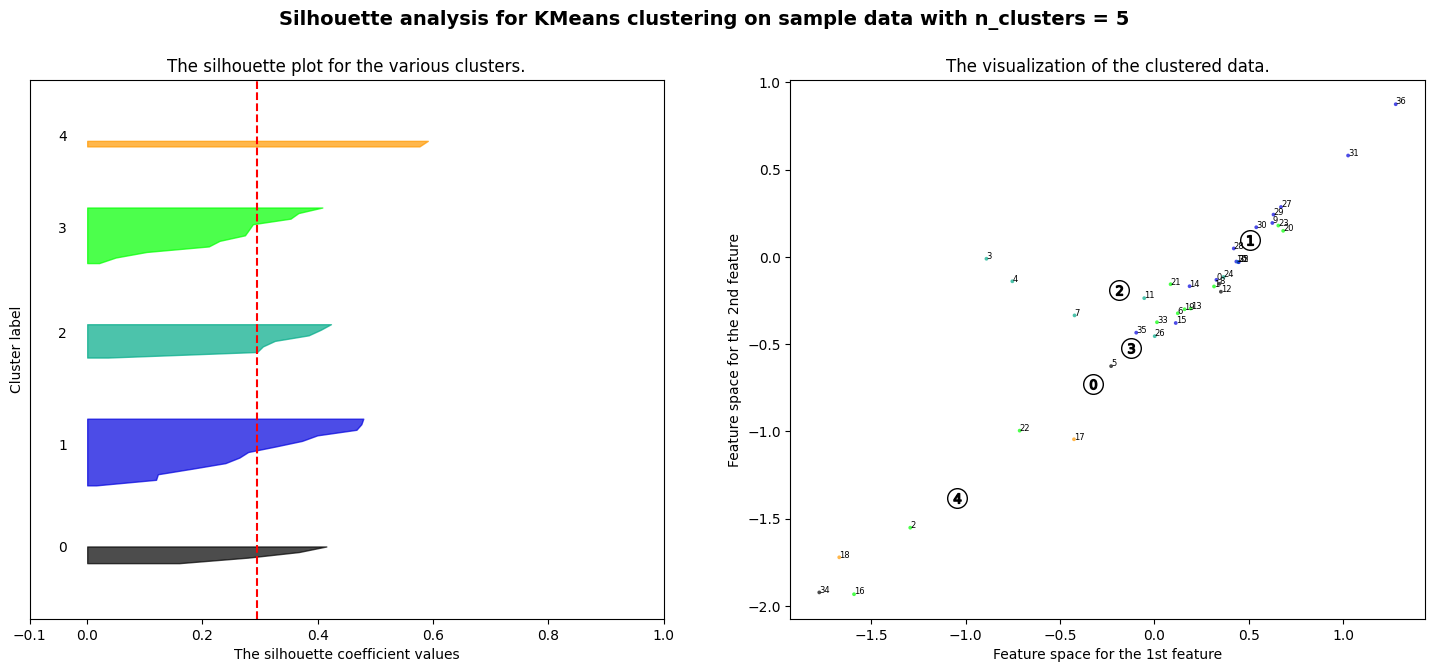

<Figure size 640x480 with 0 Axes>

In [124]:
#100 iterazioni, con X

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
#X = feature_matrix
range_n_clusters = [2, 3, 4, 5, 6, 7]

 #Indici per il conteggio di quante volte è comparso un valore negativo, dopo 100 iterazioni
i = 0 #2 cluster
j = 0 #3 cluster
k = 0 #4 cluster
l = 0 #5 cluster
m = 0 #6 cluster
n = 0 #7 cluster
#Valori per il calcolo della media di silhouette_avg
a = 0
b = 0
c = 0
d = 0
e = 0
f = 0
#Inizializzo il vettore in cui andrò a mettere tutti i silhouette_avg
iterations = 100
sil_avg = np.zeros(iterations) #dimensioni pari al numero di iterazioni
labels = np.zeros(len(X)) #41 pari al numero di modelli
centroids = np.zeros((range_n_clusters[3],len(X.T))) #5x10
max_sil_avg = -1
#Inizializzo un vettore che ha indice pari al valore delle righe, in modo tale da individuare ogni modello all'interno del plot
index_models = np.arange(len(X)) # [0,1,2,...,40]

#100 iterazioni
for p in range(iterations):
    
    for n_clusters in range_n_clusters:

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters,init='k-means++') # k-means++ per inizializzare i centroid + distanti iin modo da evitare i minimi locali
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels) #il valore medio del silhouette score tra tutti i cluster
    #    print(
    #        "For n_clusters =",
    #        n_clusters,
    #        "The average silhouette_score is :",
    #        silhouette_avg,
    #    )

        #aggiorno i valori per poi calcolare la media di silhouette_avg
        if n_clusters == range_n_clusters[0]: #2 cluster
            a = a + silhouette_avg
        elif n_clusters == range_n_clusters[1]: #3 cluster
            b = b + silhouette_avg
        elif n_clusters == range_n_clusters[2]: #4 cluster
            c = c + silhouette_avg
        elif n_clusters == range_n_clusters[3]: #5 cluster
            d = d + silhouette_avg
            #Prendo il silhouette_avg maggiore (lo faccio solo per 4 cluster) e fisso i labels e i centers
            #Inserisco silhouette_avg in un vettore
            sil_avg[p] = silhouette_avg
            if p == 0: #primo elemento dell'array sil_avg
                max_sil_avg = sil_avg[p] #fisso il primo come il massimo 
                print("iteration number",p,"max_sil_avg = ",max_sil_avg)         
            if sil_avg[p] >= max_sil_avg: # scelgo il silh. coefficient maggiore e salvo i labels e i centroids. L'uguale è per p==0
                fig.clf() #elimino il grafico pre-esistente
                labels = clusterer.labels_ #labels
                centroids = clusterer.cluster_centers_ #centroids 
                max_sil_avg = sil_avg[p] # il p-esimo elemento di sil_avg diventa il massimo valore di silhouette coefficient
                print("iteration number",p,"max_sil_avg = ",max_sil_avg)

                #plot del silhouette coefficient
                #assi per il plot
                fig, (ax1, ax2) = plt.subplots(1, 2)
                fig.set_size_inches(18,7)

                # The 1st subplot is the silhouette plot
                # The silhouette coefficient can range from -1, 1 but in this example all
                # lie within [-0.1, 1]
                ax1.set_xlim([-0.1, 1])
                # The (n_clusters+1)*10 is for inserting blank space between silhouette
                # plots of individual clusters, to demarcate them clearly.
                ax1.set_ylim([0, len(X) + (5 + 1) * 10]) #dove 4 = n_clusters perché il plot lo faccio solo per 4 clusters

                # The 1st subplot is the silhouette plot
                # The silhouette coefficient can range from -1, 1 but in this example all
                # lie within [-0.1, 1]
                ax1.set_xlim([-0.1, 1])
                # The (n_clusters+1)*10 is for inserting blank space between silhouette
                # plots of individual clusters, to demarcate them clearly.
                ax1.set_ylim([0, len(X) + (5 + 1) * 10]) # len(X) = numero di modelli e quindi il numero di samples. 4 = n_clusters perché il plot lo faccio solo per 4 clusters

                # Compute the silhouette scores for each sample
                sample_silhouette_values = silhouette_samples(X, cluster_labels)
                
                y_lower = 10
                for i in range(n_clusters):
                    # Aggregate the silhouette scores for samples belonging to
                    # cluster i, and sort them
                    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

                    ith_cluster_silhouette_values.sort()

                    size_cluster_i = ith_cluster_silhouette_values.shape[0]
                    y_upper = y_lower + size_cluster_i

                    color = cm.nipy_spectral(float(i) / n_clusters)
                    ax1.fill_betweenx(
                        np.arange(y_lower, y_upper),
                        0,
                        ith_cluster_silhouette_values,
                        facecolor=color,
                        edgecolor=color,
                        alpha=0.7,
                    )

                    # Label the silhouette plots with their cluster numbers at the middle
                    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                    # Compute the new y_lower for next plot
                    y_lower = y_upper + 10  # 10 for the 0 samples

                ax1.set_title("The silhouette plot for the various clusters.")
                ax1.set_xlabel("The silhouette coefficient values")
                ax1.set_ylabel("Cluster label")

                # The vertical line for average silhouette score of all the values
                ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

                ax1.set_yticks([])  # Clear the yaxis labels / ticks
                ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

                # 2nd Plot showing the actual clusters formed
                colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
                ax2.scatter(
                    X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
                )
                # Annotazione dei numeri degli indici
                for i, txt in enumerate(index_models):
                    ax2.annotate(txt, (X[i, 0], X[i, 1]), fontsize=6)

                # Draw white circles at cluster centers
                ax2.scatter(
                    centroids[:, 0],
                    centroids[:, 1],
                    marker="o",
                    c="white",
                    alpha=1,
                    s=200,
                    edgecolor="k",
                )

                for i, c in enumerate(centroids):
                    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

                ax2.set_title("The visualization of the clustered data.")
                ax2.set_xlabel("Feature space for the 1st feature")
                ax2.set_ylabel("Feature space for the 2nd feature")

                plt.suptitle(
                    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
                    % n_clusters,
                    fontsize=14,
                    fontweight="bold",
                )

                plt.show()
                plt.savefig('sil_coeff_X.pdf', format='pdf')

        elif n_clusters == range_n_clusters[4]: #6 cluster
            e = e + silhouette_avg  
        elif n_clusters == range_n_clusters[5]: #7 cluster
            f = f + silhouette_avg

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
        if np.any(sample_silhouette_values < 0):
            #print("For n_clusters =", n_clusters, "there are negative silhouette values.") #Se almeno uno dei samples ha sil coeff < 0
            #Aggiorno il conteggio quando ho un valore dei coefficienti negativo per ogni iterazione
            if n_clusters == range_n_clusters[0]:
                i = i + 1
            elif n_clusters == range_n_clusters[1]:
                j = j + 1
            elif n_clusters == range_n_clusters[2]:
                k = k + 1
            elif n_clusters == range_n_clusters[3]:
                l = l + 1
            elif n_clusters == range_n_clusters[4]:
                m = m + 1  
            elif n_clusters == range_n_clusters[5]:
                n = n + 1

cluster_2_mean = a / iterations
cluster_3_mean = b / iterations
cluster_4_mean = c / iterations
cluster_5_mean = d / iterations
cluster_6_mean = e / iterations
cluster_7_mean = f / iterations

#print("n_clusters = ", range_n_clusters[0], "has", i, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_2_mean)
#print("n_clusters = ", range_n_clusters[1], "has", j, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_3_mean)
#print("n_clusters = ", range_n_clusters[2], "has", k, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_4_mean)
#print("n_clusters = ", range_n_clusters[3], "has", l, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_5_mean)
#print("n_clusters = ", range_n_clusters[4], "has", m, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_6_mean)
#print("n_clusters = ", range_n_clusters[5], "has", n, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_7_mean)


In [125]:
print(labels_pca)
print(labels)

[4 0 0 3 3 2 0 3 2 4 4 3 2 0 4 4 0 1 1 0 0 0 0 0 3 3 3 4 4 4 4 4 4 0 2 4 4]
[1 3 3 2 2 0 3 2 0 1 1 2 0 3 1 1 3 4 4 3 3 3 3 3 2 2 2 1 1 1 1 1 1 3 0 1 1]


5 cluster

In [126]:
#X_pca
#Inizializzo l'indice per l'i-esimo cluster
cluster0_pca = 0
cluster1_pca = 0
cluster2_pca = 0
cluster3_pca = 0
cluster4_pca = 0
#Inizializzo le liste in cui andrò a mettere il nome dei modelli per ogni cluster
list_cluster0_pca = []
list_cluster1_pca = []
list_cluster2_pca = []
list_cluster3_pca = []
list_cluster4_pca = []
#conto quanti modelli ci sono per ogni cluster
for i in range(len(models)):
    if labels_pca[i] == 0:
        cluster0_pca = cluster0_pca + 1 #aggiorno il numero di elementi all'interno del cluster 0
        list_cluster0_pca.append(models_list[i]) #aggiungo un nome alla volta: cioè l'elemento j-esimo della lista dei nomi del cluster 0 è pari all'elemento i-esimo della lista dei nomi di tutti i modelli
    elif labels_pca[i] == 1:
        cluster1_pca = cluster1_pca + 1
        list_cluster1_pca.append(models_list[i])
        #print(i,cluster_1)
    elif labels_pca[i] == 2:
        cluster2_pca = cluster2_pca + 1
        list_cluster2_pca.append(models_list[i])
    elif labels_pca[i] == 3:
        cluster3_pca = cluster3_pca + 1
        list_cluster3_pca.append(models_list[i])
    elif labels_pca[i] == 4:
        cluster4_pca = cluster4_pca + 1
        list_cluster4_pca.append(models_list[i])

print(cluster0_pca,cluster1_pca,cluster2_pca,cluster3_pca,cluster4_pca)
print(sum([cluster0_pca,cluster1_pca,cluster2_pca,cluster3_pca,cluster4_pca]))
print(list_cluster0_pca)
print(list_cluster1_pca)
print(list_cluster2_pca)
print(list_cluster3_pca)
print(list_cluster4_pca)

11 2 4 7 13
37
['AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'CAS-ESM2-0', 'EC-Earth3', 'MPI-ESM-1-2-HAM', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'GFDL-ESM4']
['INM-CM4-8', 'INM-CM5-0']
['CAMS-CSM1-0', 'CanESM5', 'E3SM-1-0', 'NESM3']
['BCC-CSM2-MR', 'BCC-ESM1', 'FGOALS-g3', 'ACCESS-CM2', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H']
['TaiESM1', 'CMCC-CM2-SR5', 'ACCESS-ESM1-5', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'MCM-UA-1-0']


In [127]:
#X
#Inizializzo l'indice per l'i-esimo cluster
cluster0 = 0
cluster1 = 0
cluster2 = 0
cluster3 = 0
cluster4 = 0
#Inizializzo le liste in cui andrò a mettere il nome dei modelli per ogni cluster
list_cluster0 = []
list_cluster1 = []
list_cluster2 = []
list_cluster3 = []
list_cluster4 = []
#conto quanti modelli ci sono per ogni cluster
for i in range(len(models)):
    if labels[i] == 0:
        cluster0 = cluster0 + 1 #aggiorno il numero di elementi all'interno del cluster 0
        list_cluster0.append(models_list[i]) #aggiungo un nome alla volta: cioè l'elemento j-esimo della lista dei nomi del cluster 0 è pari all'elemento i-esimo della lista dei nomi di tutti i modelli
    elif labels[i] == 1:
        cluster1 = cluster1 + 1
        list_cluster1.append(models_list[i])
        #print(i,cluster_1)
    elif labels[i] == 2:
        cluster2 = cluster2 + 1
        list_cluster2.append(models_list[i])
    elif labels[i] == 3:
        cluster3 = cluster3 + 1
        list_cluster3.append(models_list[i])
    elif labels[i] == 4:
        cluster4 = cluster4 + 1
        list_cluster4.append(models_list[i])

print(cluster0,cluster1,cluster2,cluster3,cluster4)
print(sum([cluster0,cluster1,cluster2,cluster3,cluster4]))
print(list_cluster0)
print(list_cluster1)
print(list_cluster2)
print(list_cluster3)
print(list_cluster4)

4 13 7 11 2
37
['CAMS-CSM1-0', 'CanESM5', 'E3SM-1-0', 'NESM3']
['TaiESM1', 'CMCC-CM2-SR5', 'ACCESS-ESM1-5', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'MCM-UA-1-0']
['BCC-CSM2-MR', 'BCC-ESM1', 'FGOALS-g3', 'ACCESS-CM2', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H']
['AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'CAS-ESM2-0', 'EC-Earth3', 'MPI-ESM-1-2-HAM', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'GFDL-ESM4']
['INM-CM4-8', 'INM-CM5-0']


In [128]:
print(list_cluster0_pca)
print(list_cluster1_pca)
print(list_cluster2_pca)
print(list_cluster3_pca)
print(list_cluster4_pca)
print('\n')
print(list_cluster0)
print(list_cluster1)
print(list_cluster2)
print(list_cluster3)
print(list_cluster4)

['AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'CAS-ESM2-0', 'EC-Earth3', 'MPI-ESM-1-2-HAM', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'GFDL-ESM4']
['INM-CM4-8', 'INM-CM5-0']
['CAMS-CSM1-0', 'CanESM5', 'E3SM-1-0', 'NESM3']
['BCC-CSM2-MR', 'BCC-ESM1', 'FGOALS-g3', 'ACCESS-CM2', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H']
['TaiESM1', 'CMCC-CM2-SR5', 'ACCESS-ESM1-5', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'MCM-UA-1-0']


['CAMS-CSM1-0', 'CanESM5', 'E3SM-1-0', 'NESM3']
['TaiESM1', 'CMCC-CM2-SR5', 'ACCESS-ESM1-5', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'MCM-UA-1-0']
['BCC-CSM2-MR', 'BCC-ESM1', 'FGOALS-g3', 'ACCESS-CM2', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H']
['AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'CAS-ESM2-0', 'EC-Earth3', 'MPI-ESM-1-2-HAM', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-

Fisso nome modelli e numero all'interno delle liste per ogni cluster

In [129]:
#fisso il nome dei modelli all'interno delle liste dei singoli cluster
list_cluster0_pca = ['CAMS-CSM1-0', 'CanESM5', 'E3SM-1-0', 'NESM3']
list_cluster1_pca = ['BCC-CSM2-MR', 'BCC-ESM1', 'FGOALS-g3', 'ACCESS-CM2', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H']
list_cluster2_pca = ['TaiESM1', 'CMCC-CM2-SR5', 'ACCESS-ESM1-5', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'MCM-UA-1-0']
list_cluster3_pca = ['AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'CAS-ESM2-0', 'EC-Earth3', 'MPI-ESM-1-2-HAM', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'GFDL-ESM4']
list_cluster4_pca = ['INM-CM4-8', 'INM-CM5-0']

In [130]:
#fisso il numero di elementi all'interno
cluster0_pca = len(list_cluster0_pca)
cluster1_pca = len(list_cluster1_pca)
cluster2_pca = len(list_cluster2_pca)
cluster3_pca = len(list_cluster3_pca)
cluster4_pca = len(list_cluster4_pca)

X_pca

Cluster0_pca

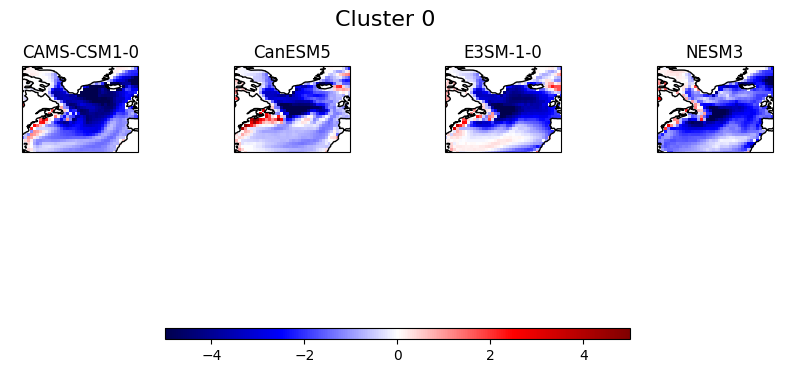

In [131]:
plot_bias_tos((int(cluster0_pca/4)+1),4,(10,4),cluster0_pca,list_cluster0_pca,models,-5,5,'Cluster 0','cluster_0_pca.pdf')

Cluster 1_pca

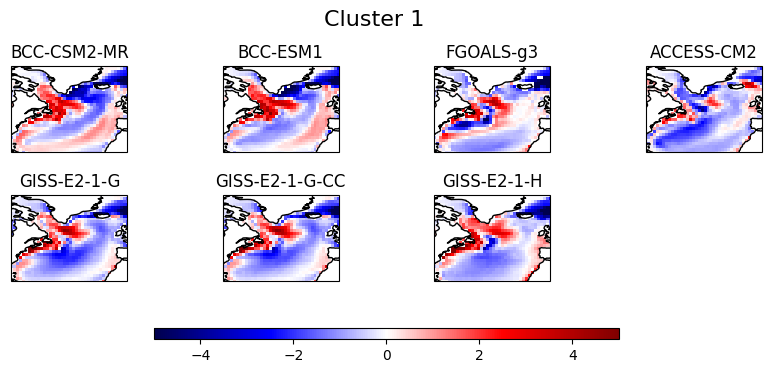

In [132]:
plot_bias_tos((int(cluster1_pca/4)+1),4,(10,4),cluster1_pca,list_cluster1_pca,models,-5,5,'Cluster 1','cluster_1_pca.pdf')

Cluster 2_pca

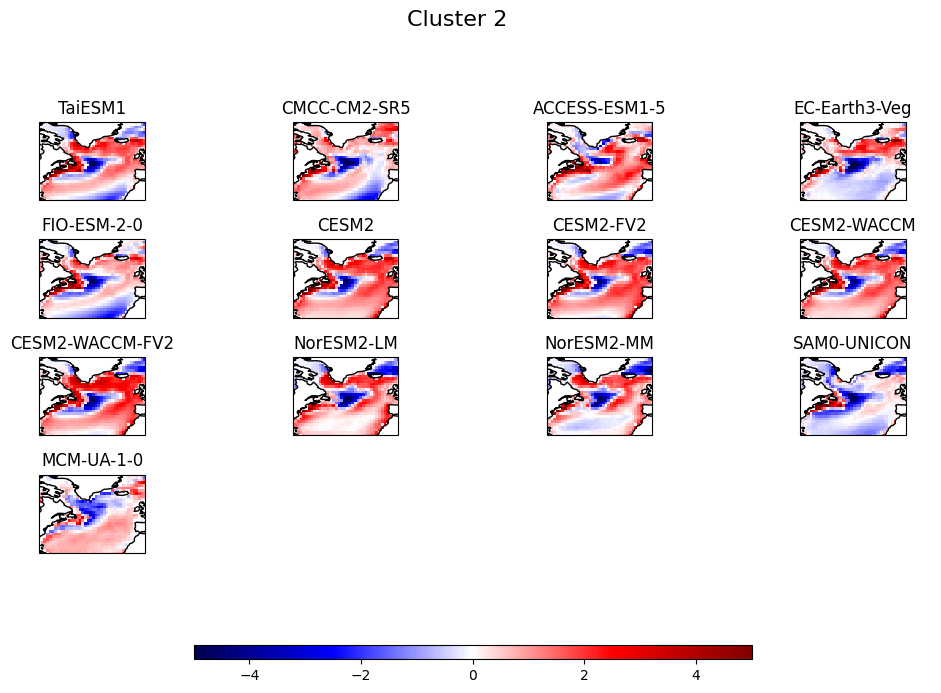

In [133]:
plot_bias_tos((int(cluster2_pca/4)+1),4,(12,8),cluster2_pca,list_cluster2_pca,models,-5,5,'Cluster 2','cluster_2_pca.pdf')

Cluster 3_pca

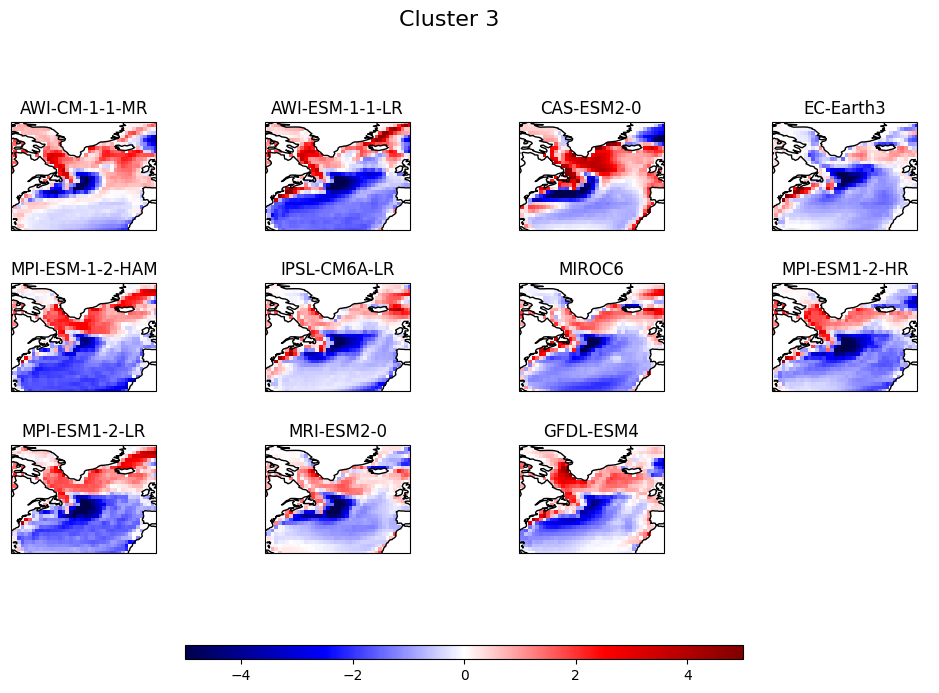

In [134]:
plot_bias_tos((int(cluster3_pca/4)+1),4,(12,8),cluster3_pca,list_cluster3_pca,models,-5,5,'Cluster 3','cluster_3_pca.pdf')

Cluster 4_pca

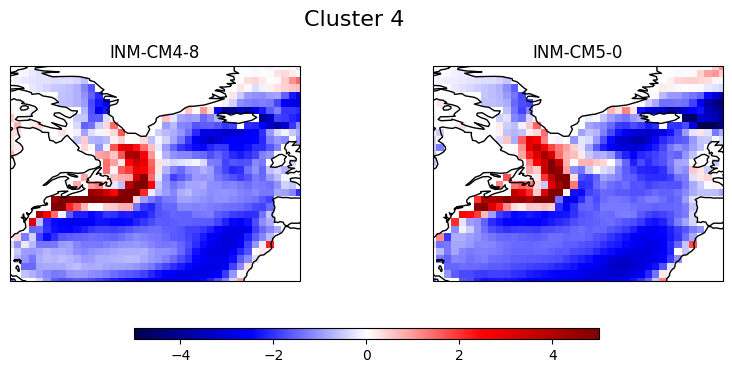

In [135]:
plot_bias_2_models_tos((10,4),-5,5,list_cluster4_pca,models,'Cluster 4','cluster_4_pca.pdf')

Cluster medio pca

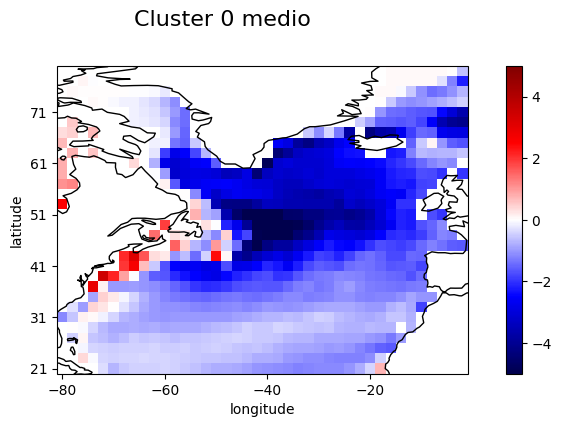

In [136]:
plot_mean_cluster_tos(cluster0_pca,list_cluster0_pca,models,'Cluster 0 medio','cluster_0_mean_pca.pdf',-5,5,(10,4))

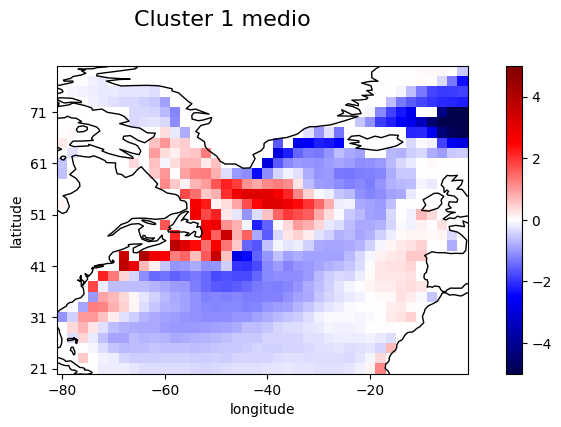

In [137]:
plot_mean_cluster_tos(cluster1_pca,list_cluster1_pca,models,'Cluster 1 medio','cluster_1_mean_pca.pdf',-5,5,(10,4))

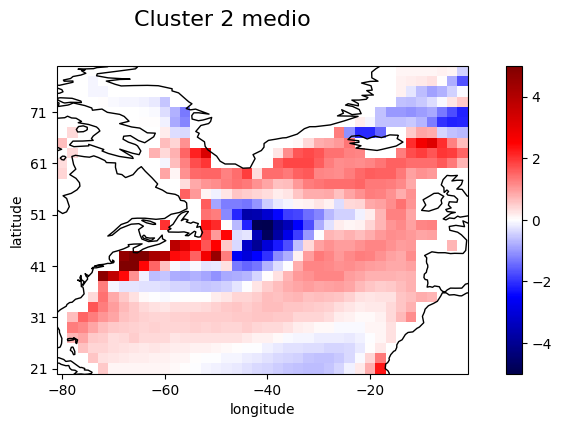

In [138]:
plot_mean_cluster_tos(cluster2_pca,list_cluster2_pca,models,'Cluster 2 medio','cluster_2_mean_pca.pdf',-5,5,(10,4))

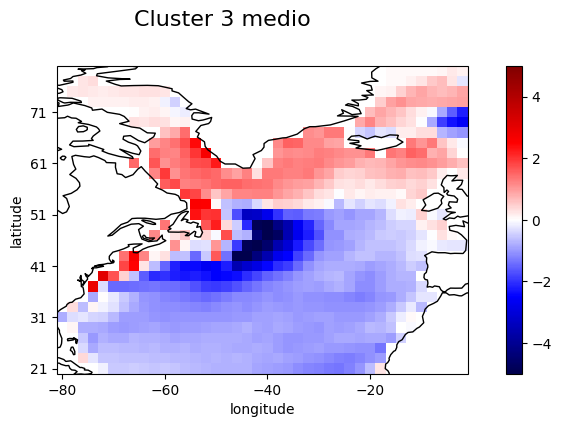

In [139]:
plot_mean_cluster_tos(cluster3_pca,list_cluster3_pca,models,'Cluster 3 medio','cluster_3_mean_pca.pdf',-5,5,(10,4))

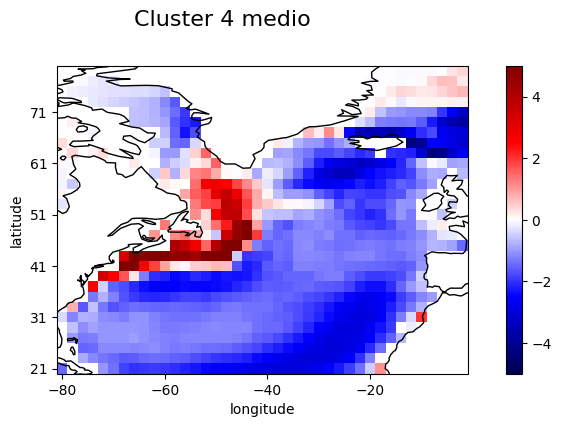

In [140]:
plot_mean_cluster_tos(cluster4_pca,list_cluster4_pca,models,'Cluster 4 medio','cluster_4_mean_pca.pdf',-5,5,(10,4))

Salvataggio di models e di liste/immagini in pickle

In [141]:
# Salvataggio di models
with open('models.pkl', 'wb') as file:
    dill.dump(models, file)
    dill.dump(esa_na_seas_mean_tos,file)
    dill.dump(dataset_ESA_na_celsius,file)

In [142]:
# Salvataggio liste e immagini pdf in un file Pickle
with open('modelli_tos.pickle', 'wb') as f: #'wb' = write binary
    pickle.dump(list_cluster0_pca, f) #salvataggio lista con nomi cluster
    pickle.dump(list_cluster1_pca, f)
    pickle.dump(list_cluster2_pca, f)
    pickle.dump(list_cluster3_pca, f)
    pickle.dump(list_cluster4_pca, f)
    pickle.dump('cluster_0_pca.pdf', f) #salvataggio immagini modelli per ogni cluster
    pickle.dump('cluster_1_pca.pdf', f)
    pickle.dump('cluster_2_pca.pdf', f)
    pickle.dump('cluster_3_pca.pdf', f)
    pickle.dump('cluster_4_pca.pdf', f)    
    pickle.dump('cluster_0_mean_pca.pdf', f) #salvataggio immagini cluster medio
    pickle.dump('cluster_1_mean_pca.pdf', f)    
    pickle.dump('cluster_2_mean_pca.pdf', f)    
    pickle.dump('cluster_3_mean_pca.pdf', f)    
    pickle.dump('cluster_4_mean_pca.pdf', f)

NO

X

Cluster 0

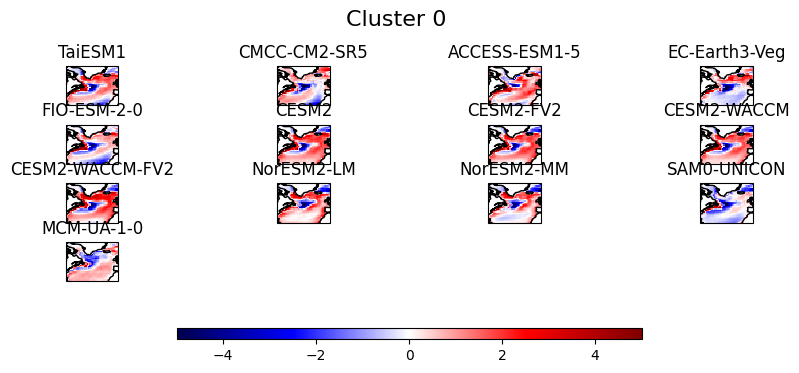

In [71]:
plot_bias_tos((int(cluster0/4)+1),4,(10,4),cluster0,list_cluster0,models,-5,5,'Cluster 0','cluster_0.pdf')

Cluster 1

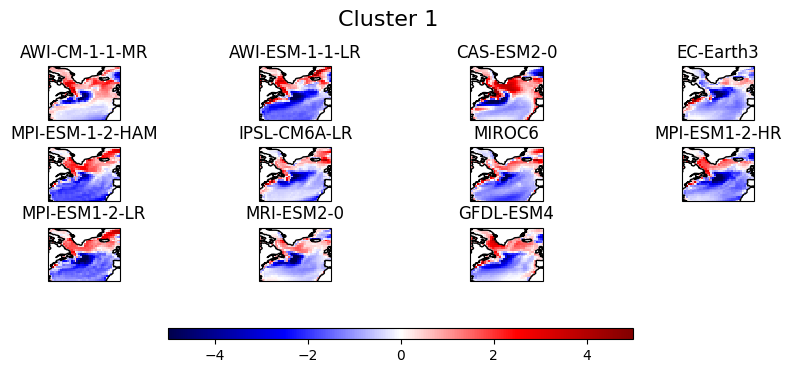

In [72]:
plot_bias_tos((int(cluster1/4)+1),4,(10,4),cluster1,list_cluster1,models,-5,5,'Cluster 1','cluster_1.pdf')

Cluster 2

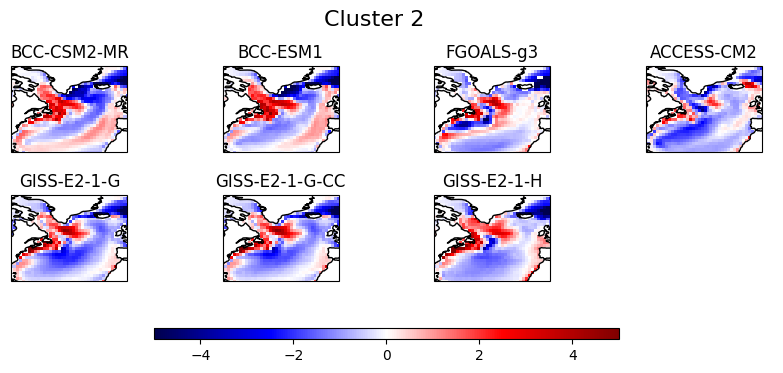

In [73]:
plot_bias_tos((int(cluster2/4)+1),4,(10,4),cluster2,list_cluster2,models,-5,5,'Cluster 2','cluster_2.pdf')

Cluster 3

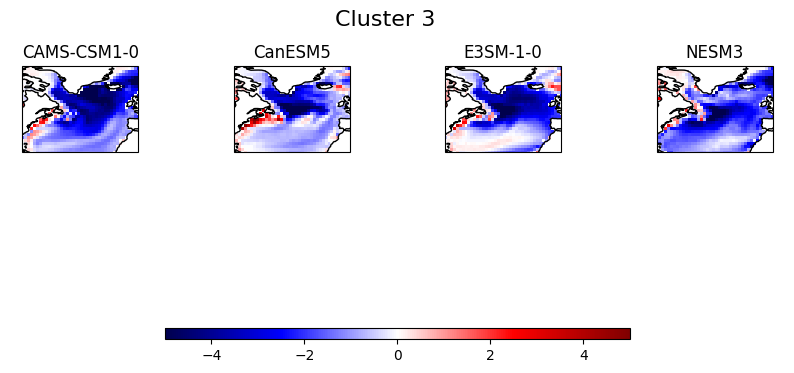

In [74]:
plot_bias_tos((int(cluster3/4)+1),4,(10,4),cluster3,list_cluster3,models,-5,5,'Cluster 3','cluster_3.pdf')

Cluster 4

In [75]:
plot_bias_2_models_tos((10,4),list_cluster4,models,'Cluster 4','cluster_4.pdf')

TypeError: plot_bias_2_models_tos() missing 2 required positional arguments: 'title_plot' and 'title_pdf'

Cluster medio

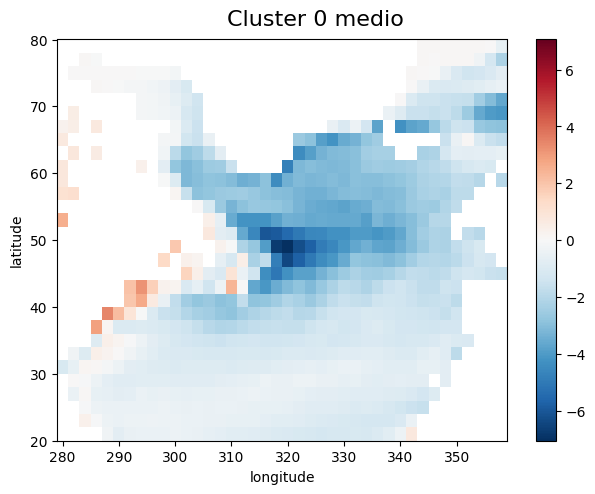

In [ ]:
plot_mean_cluster_tos(cluster0,list_cluster0,models,'Cluster 0 medio','cluster_0_mean.pdf')

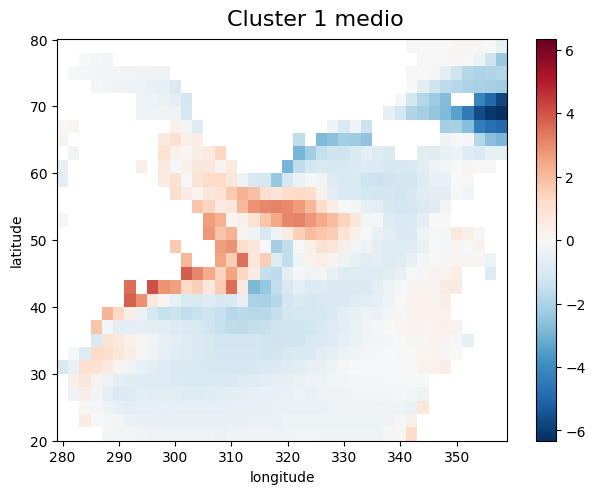

In [ ]:
plot_mean_cluster_tos(cluster1,list_cluster1,models,'Cluster 1 medio','cluster_1_mean.pdf')

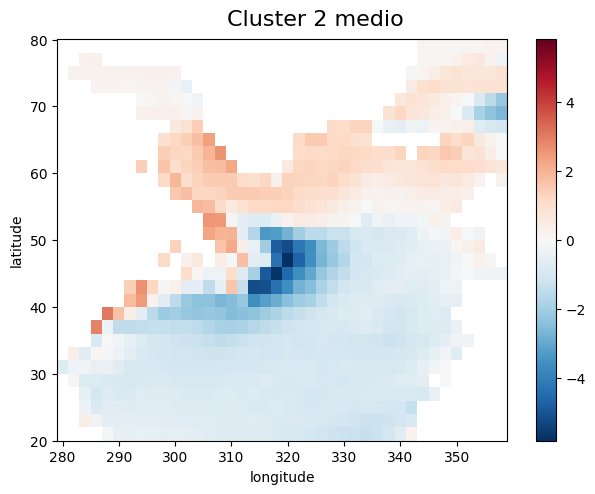

In [ ]:
plot_mean_cluster_tos(cluster2,list_cluster2,models,'Cluster 2 medio','cluster_2_mean.pdf')

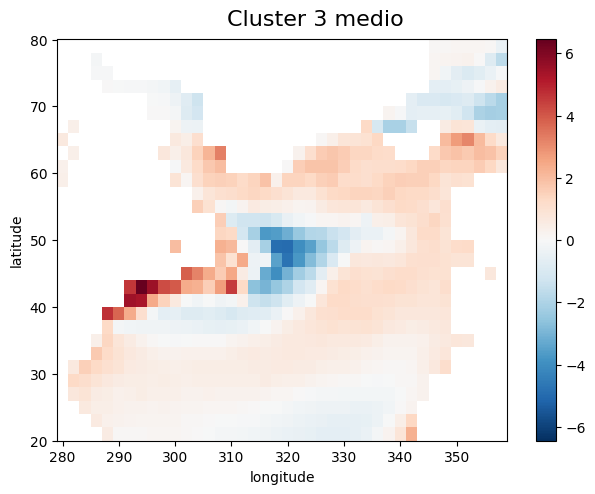

In [ ]:
plot_mean_cluster_tos(cluster3,list_cluster3,models,'Cluster 3 medio','cluster_3_mean.pdf')

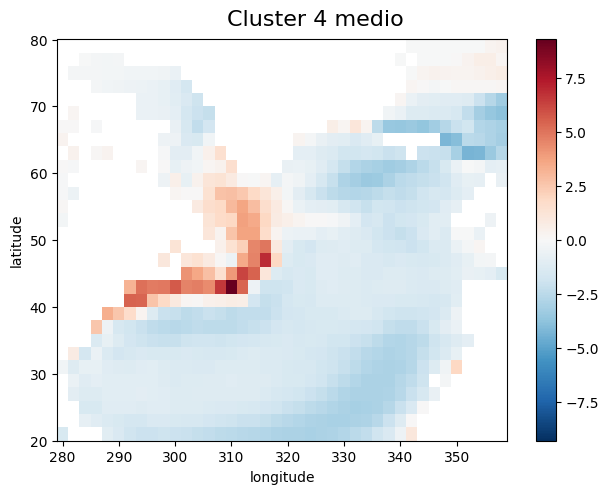

In [ ]:
plot_mean_cluster_tos(cluster4,list_cluster4,models,'Cluster 4 medio','cluster_4_mean.pdf')

NO

Plot dei bias per ogni stagione

MAM

/tmp/ipykernel_533780/3836943220.py:13: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[i,j].legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is

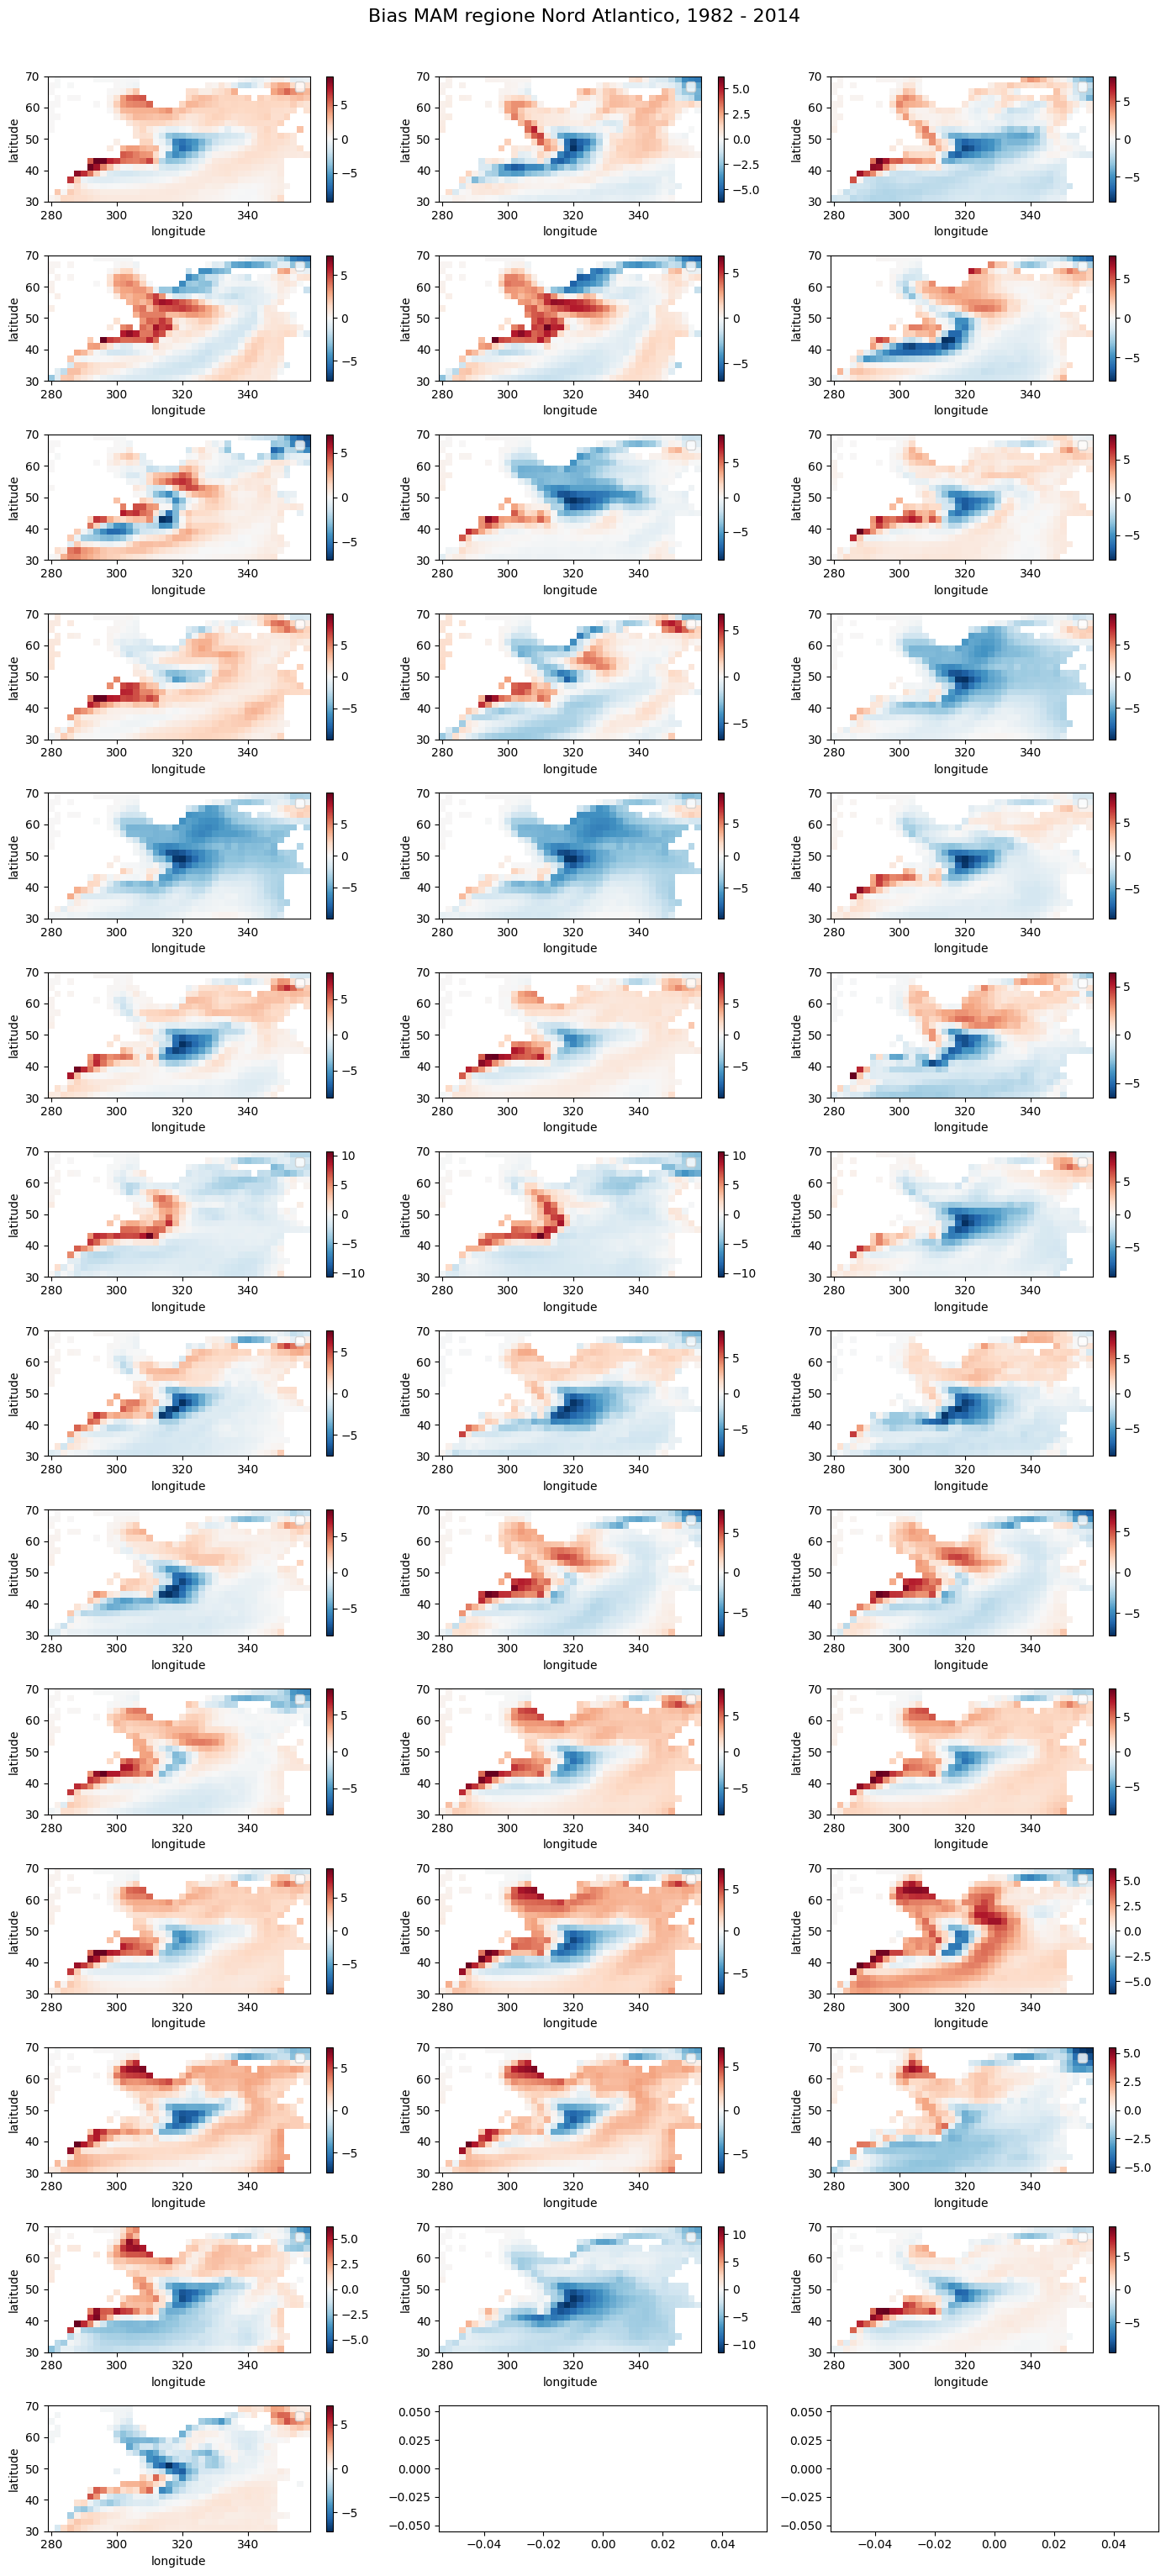

In [ ]:
#MAM
#Plot dei modelli
fig, ax = plt.subplots(nrows=14,ncols=3,figsize=(14,30))
# Plot dei modelli
for i in range(14): #ciclo sulle righe 7
    for j in range(3): #ciclo sulle colonne 6
        models_index_list = i*3 + j #indice del modello all'interno della lista
        if models_index_list == len(models_list):
            break
        model_name = models_list[models_index_list]
        data_array = models[model_name]['North Atlantic bias MAM']#.copy()
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()   
        ax[i,j].set_ylabel('latitude')
        ax[i,j].set_xlabel('longitude')

for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()

# Titolo
fig.suptitle('Bias MAM regione Nord Atlantico, 1982 - 2014', fontsize=16, y=1.02)
plt.savefig('bias_MAM.pdf', format='pdf')

JJA

/tmp/ipykernel_1269/3392657668.py:11: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[i,j].legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is c

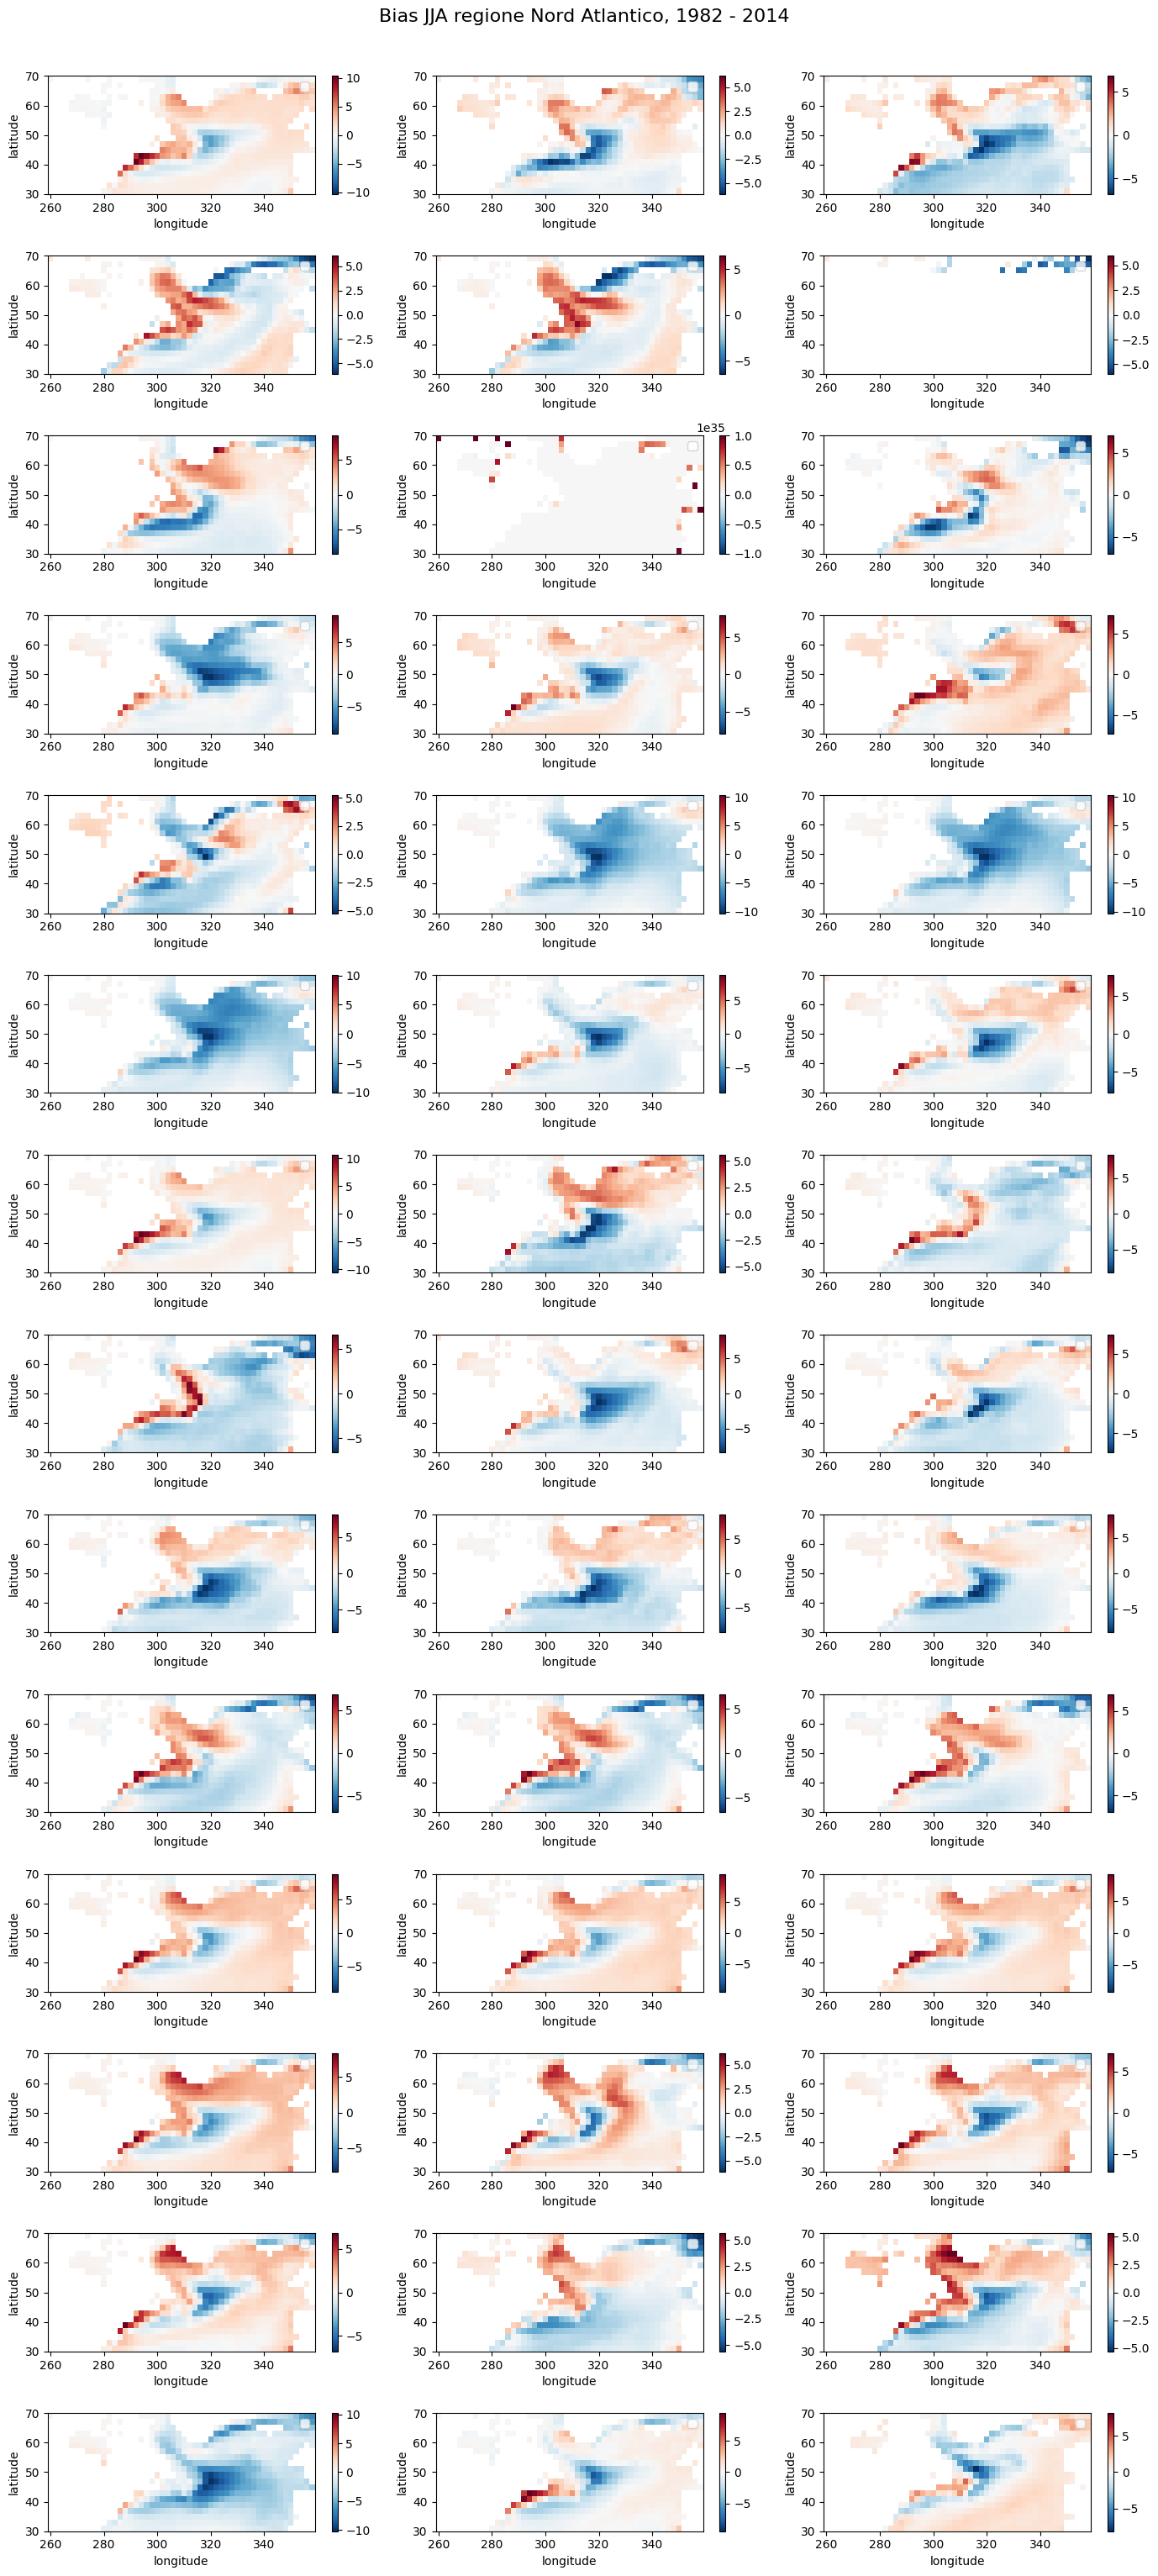

In [ ]:
#JJA
#Plot dei modelli
fig, ax = plt.subplots(nrows=14,ncols=3,figsize=(14,30))
# Plot dei modelli
for i in range(14): #ciclo sulle righe 7
    for j in range(3): #ciclo sulle colonne 6
        models_index_list = i*3 + j #indice del modello all'interno della lista
        if models_index_list == len(models_list):
            break
        model_name = models_list[models_index_list]
        data_array = models[model_name]['North Atlantic bias JJA']#.copy()
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()   
        ax[i,j].set_ylabel('latitude')
        ax[i,j].set_xlabel('longitude')

for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()

# Titolo
fig.suptitle('Bias JJA regione Nord Atlantico, 1982 - 2014', fontsize=16, y=1.02)
plt.savefig('bias_JJA.pdf', format='pdf')

SON

/tmp/ipykernel_1269/2039816427.py:11: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[i,j].legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is c

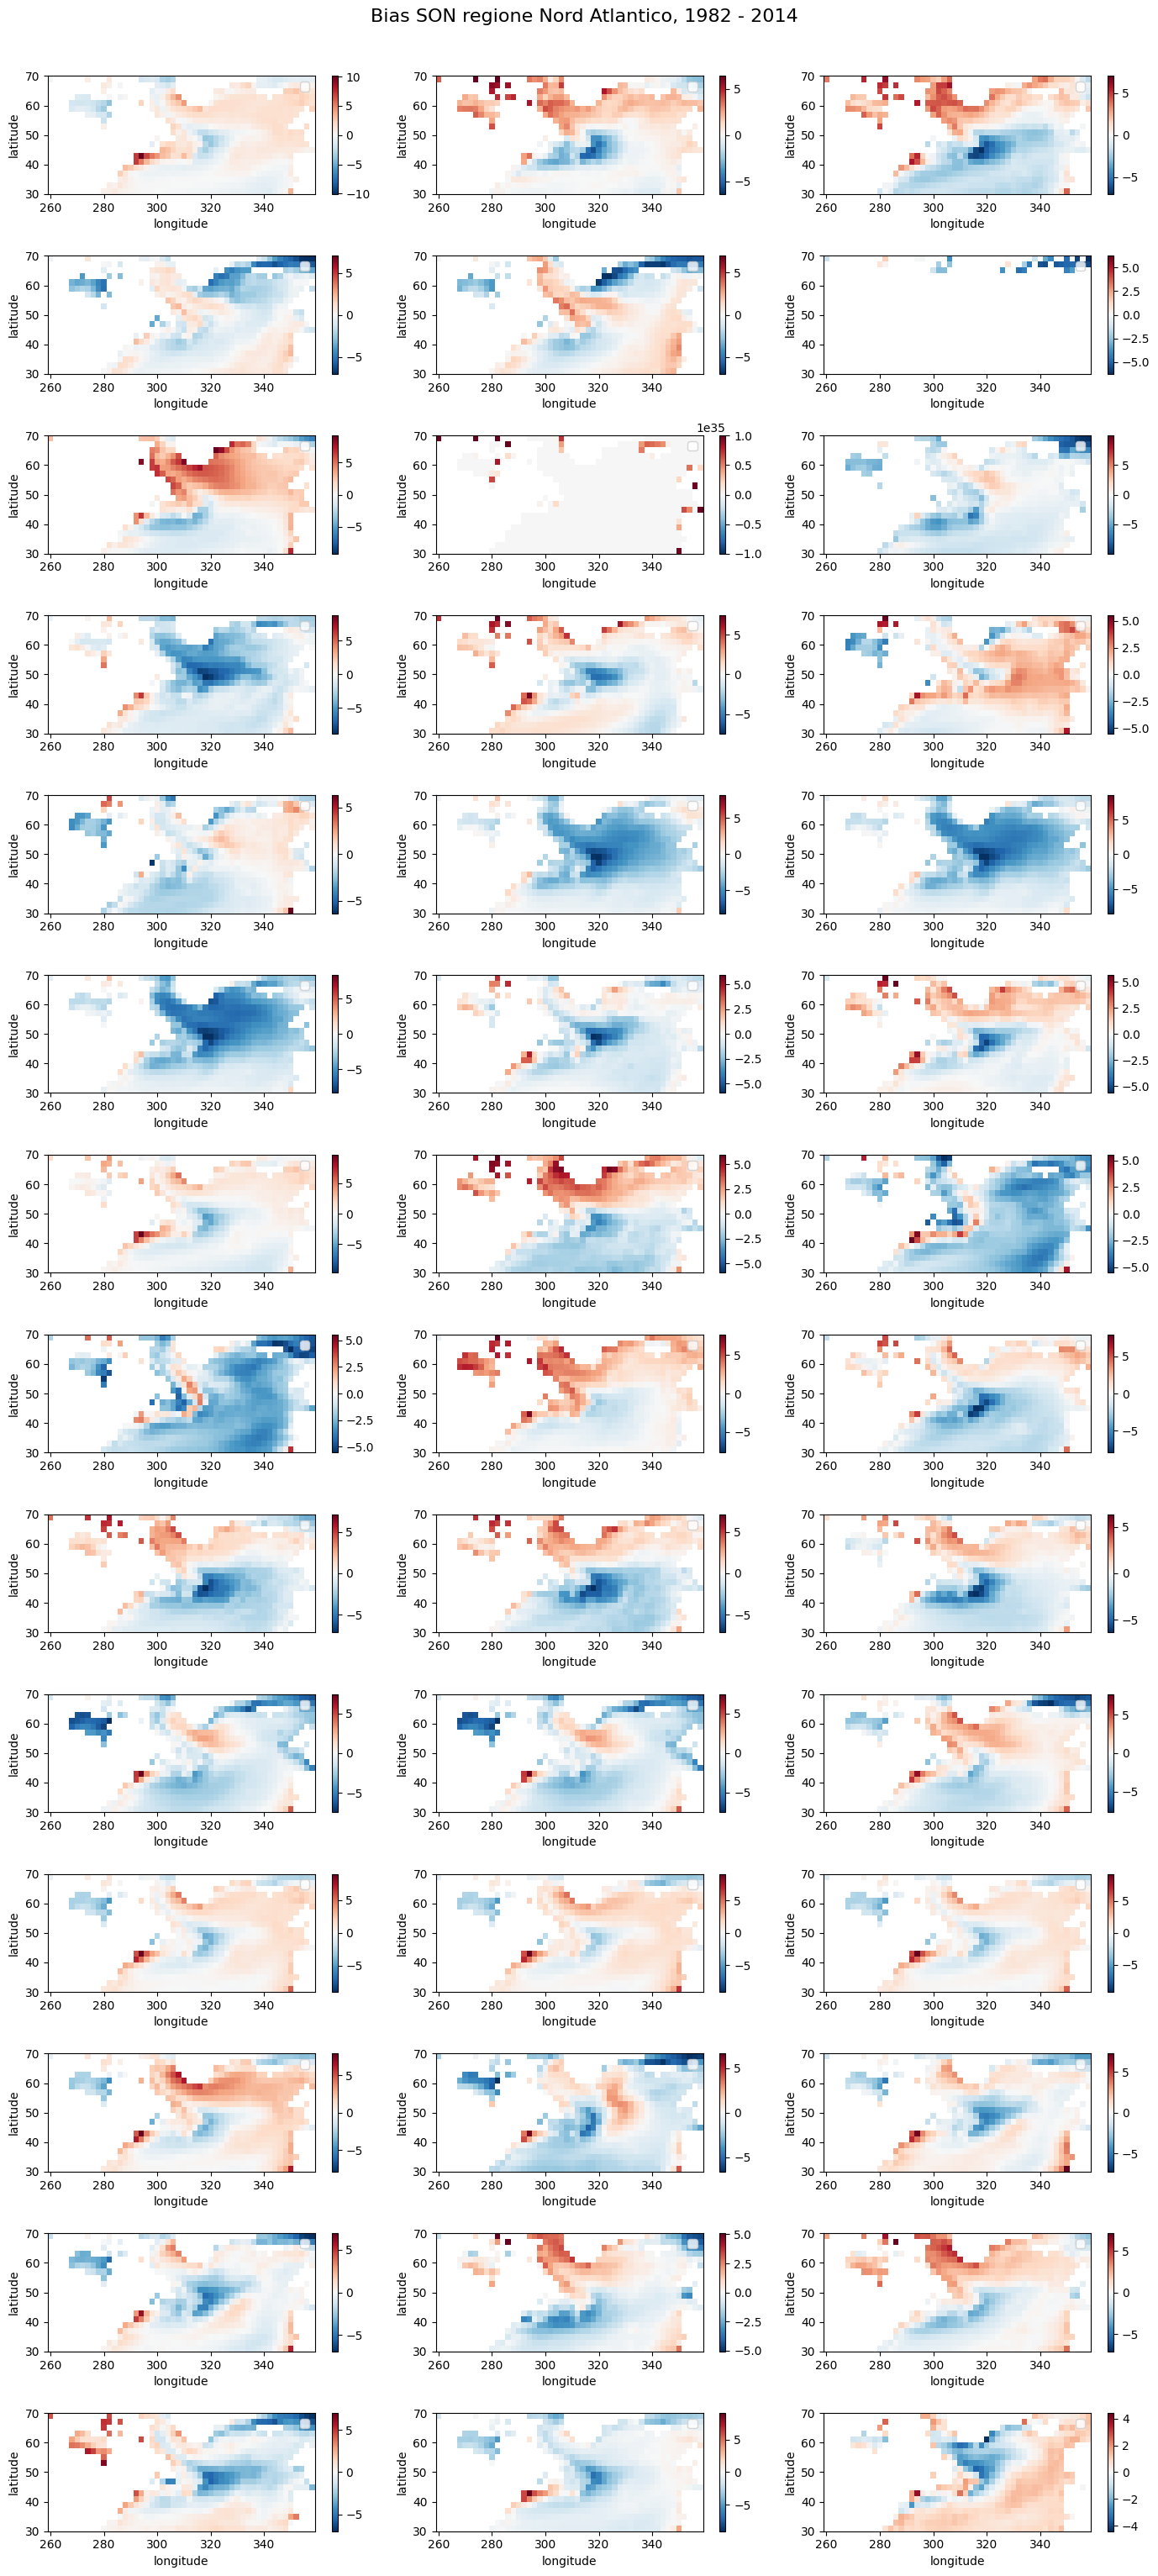

In [ ]:
#SON
#Plot dei modelli
fig, ax = plt.subplots(nrows=14,ncols=3,figsize=(14,30))
# Plot dei modelli
for i in range(14): #ciclo sulle righe 7
    for j in range(3): #ciclo sulle colonne 6
        models_index_list = i*3 + j #indice del modello all'interno della lista
        if models_index_list == len(models_list):
            break
        model_name = models_list[models_index_list]
        data_array = models[model_name]['North Atlantic bias SON']#.copy()
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()   
        ax[i,j].set_ylabel('latitude')
        ax[i,j].set_xlabel('longitude')

for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()

# Titolo
fig.suptitle('Bias SON regione Nord Atlantico, 1982 - 2014', fontsize=16, y=1.02)
plt.savefig('bias_SON.pdf', format='pdf')

DJF

/tmp/ipykernel_1269/3842991416.py:11: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[i,j].legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is c

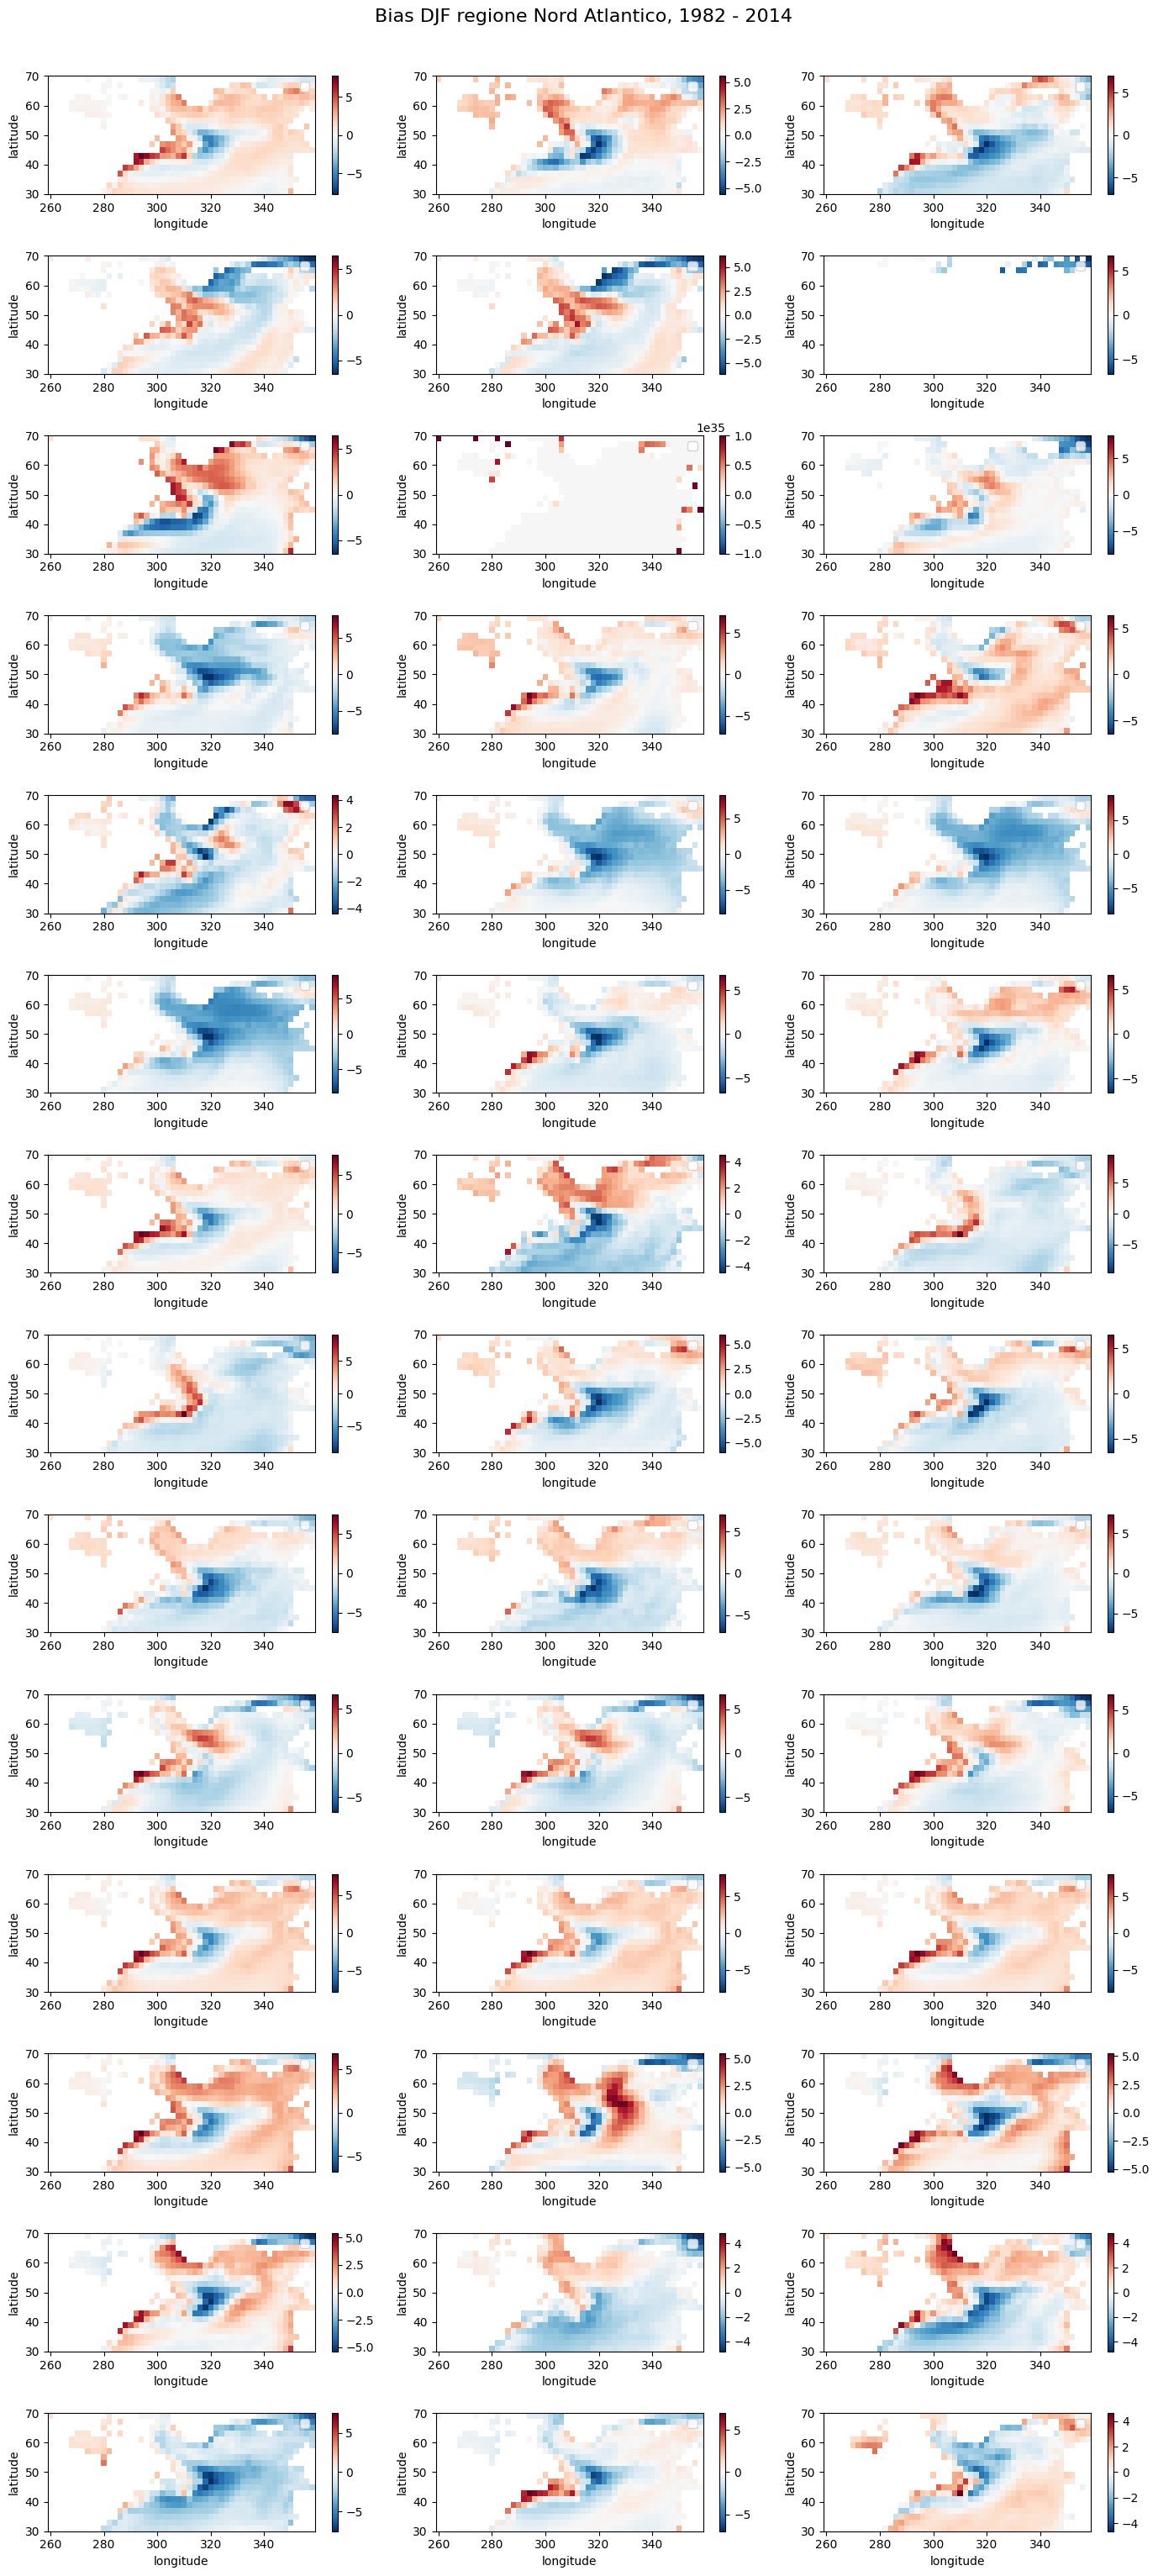

In [ ]:
#DJF
#Plot dei modelli
fig, ax = plt.subplots(nrows=14,ncols=3,figsize=(14,30))
# Plot dei modelli
for i in range(14): #ciclo sulle righe 7
    for j in range(3): #ciclo sulle colonne 6
        models_index_list = i*3 + j #indice del modello all'interno della lista
        if models_index_list == len(models_list):
            break
        model_name = models_list[models_index_list]
        data_array = models[model_name]['North Atlantic bias DJF']#.copy()
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()   
        ax[i,j].set_ylabel('latitude')
        ax[i,j].set_xlabel('longitude')

for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()

# Titolo
fig.suptitle('Bias DJF regione Nord Atlantico, 1982 - 2014', fontsize=16, y=1.02)
plt.savefig('bias_DJF.pdf', format='pdf')

prova con soli 3 modelli

In [ ]:
models = { 'Ec-Earth3':
                    {'path': '/work/users/guest/sbeltrami/tostest.nc',
                     },
            'IPSL-CM6A-LR':
                    {'path': '/work/users/guest/sbeltrami/tostest_ipsl.nc',
                     },
            'MPI-ESM1-2-HR':
                    {'path': '/work/users/guest/sbeltrami/tostest_mpi.nc',
                     }
         }

In [ ]:
for name in models.keys():
    #apertura modelli
    dataset = xr.open_dataset(models[name]['path'])
    #peso il dataset
    models[name]['dataset weighted'] = compute_dataset_weighted(dataset["tos"])
    #medie annuali con dataset pesato
    models[name]['annual mean'] = compute_annual_mean_weighted(models[name]['dataset weighted'])


FileNotFoundError: [Errno 2] No such file or directory: '/work/users/guest/sbeltrami/tostest.nc'

In [ ]:
models['Ec-Earth3'].keys()

dict_keys(['path', 'dataset weighted', 'annual mean'])

In [ ]:
models['Ec-Earth3'].items()

Prova bias metodo + lungo

In [ ]:
dataset_ESA_na_celsius_period = dataset_ESA_na_celsius.sel(time=slice("1983-12","2014-11"))
#dizionario in cui metto la media temporale delle stagioni per il dataset esa
esa_na_seas_mean = {}
#Dataset ESA-CCI: calcolo della media temporale per le stagioni MAM, JJA, SON
for seas in ['MAM','JJA','SON']:
    esa_na_seas_mean[seas] = compute_mean_time_season(dataset_ESA_na_celsius_period,seas)
#Dataset ESA-CCI: seleziona dicembre dell'anno precedente e gennaio/ febbraio dell'anno successivo e calcolo la media sul tempo
esa_na_seas_mean['DJF'] = create_djf_dataset(dataset_ESA_na_celsius_period,1983).mean(dim='time')
#esa_na_seas_mean['MAM'].keys()
type(esa_na_seas_mean)
esa_na_seas_mean['DJF']

In [ ]:
#Bias modelli
for name in models:
    #Seleziono l'anno su cui voglio calcolare il bias di tos
    dataset = xr.open_dataset(models[name]['path remap'])
    #Seleziono il box del Nord Atlantico
    na_box = dataset.sel(lon=slice(260,360), lat=slice(30,70))
    period = na_box["tos"].sel(time=slice("1983-12","1984-11"))
    if name == 'CIESM':
        print("Errore da risolvere con CIESM")
    else:
        #media temporale delle stagioni MAM, JJA, SON
        for seas in ['MAM','JJA','SON']:
            model_na_seas_mean = compute_mean_time_season(period,seas)
            if seas == 'MAM':
                models[name]['Nord Atlantic bias MAM'] = model_na_seas_mean - esa_na_seas_mean[seas]
            elif seas == 'JJA':
                models[name]['Nord Atlantic bias JJA'] = model_na_seas_mean - esa_na_seas_mean[seas]
            elif seas == 'SON':
                models[name]['Nord Atlantic bias SON'] = model_na_seas_mean - esa_na_seas_mean[seas]
        #media temporale per DJF
        model_na_djf_mean = create_djf_dataset(period,1983).mean(dim='time')
        models[name]['Nord Atlantic bias DJF'] = model_na_djf_mean - esa_na_seas_mean['DJF']

